**EDA Objective:** Identify and retain low-cost NHANES variables that may help predict costly or invasive lab biomarkers (vitamin D, HDL cholesterol, A1C).

- Data: NHANES 2013–2014 (public .xpt files)
- Targets: vitamin_d, hdl_cholesterol, a1c
- Inputs: demographics, smoking/alcohol, vitals, occupation, physical activity

In [115]:
# install and load packages/libraries

!pip install pyreadstat
import pyreadstat
from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D


# Set global plot style
plt.rcParams.update({
    'font.family': 'DejaVu Sans',  
    'axes.grid': False,
    'figure.dpi': 400,             # High-resolution
    'axes.titlesize': 0,           # No titles unless explicitly set
    'axes.labelsize': 7,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
})
sns.set_style("white")  # Removes background grid lines

# Set global font properties
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 7

In [3]:
# potential features
df_a, meta_a = pyreadstat.read_xport("../data/ALQ_I.xpt.txt") # Alcohol Use (ALQ_I)
df_b, meta_b = pyreadstat.read_xport("../data/BMX_I.xpt.txt") # Body Measures (BMX_I)
df_bp, meta_bp = pyreadstat.read_xport("../data/BPX_I.xpt.txt") # Blood Pressure (BPX_I)
df_d, meta_d = pyreadstat.read_xport("../data/DEMO_I.xpt.txt") # Demographic Variables and Sample Weights (DEMO_I)
df_i, meta_i = pyreadstat.read_xport("../data/INQ_I.xpt.txt") # Income (INQ_I)
df_o, meta_o = pyreadstat.read_xport("../data/OCQ_I.xpt.txt") # Occupation (OCQ_I)
df_pa, meta_pa = pyreadstat.read_xport("../data/PAQ_I.xpt.txt") # Physical Activity (PAQ_I)
df_c, meta_c = pyreadstat.read_xport("../data/SMQ_I.xpt.txt") # Smoking - Cigarette Use (SMQ_I)

# potential targets
df_ac, meta_ac = pyreadstat.read_xport("../data/ALB_CR_I.xpt.txt") # Albumin & Creatinine - Urine (ALB_CR_I)
df_g, meta_g = pyreadstat.read_xport("../data/GHB_I.xpt.txt") # Glycohemoglobin (GHB_I)
df_hdl, meta_hdl = pyreadstat.read_xport("../data/HDL_I.xpt.txt") # Cholesterol - High-Density Lipoprotein (HDL) (HDL_I)
df_ldl, meta_ldl = pyreadstat.read_xport("../data/TRIGLY_I.xpt.txt") # Cholesterol - Low - Density Lipoprotein (LDL) & Triglycerides (TRIGLY_I)
df_v, meta_v = pyreadstat.read_xport("../data/VID_I.xpt.txt") # Vitamin D (VID_I)

In [4]:
# Add all dataframes to a list
dfs = [df_a, df_b, df_bp, df_d, df_i, df_o, df_pa, df_c, df_ac, df_g, df_hdl, df_ldl, df_v]

# Reduce them into a single merged df on SEQN
df_merged = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='outer'), dfs)

# Preview
print(df_merged.shape)
df_merged.head()

(9971, 286)


SEQN  ALQ101  ALQ110  ALQ120Q  ALQ120U  ALQ130  ALQ141Q  ALQ141U  \
0  83732.0     1.0     NaN      1.0      2.0     1.0      0.0      NaN   
1  83733.0     1.0     NaN      7.0      1.0     6.0      7.0      1.0   
2  83734.0     1.0     NaN      0.0      NaN     NaN      NaN      NaN   
3  83735.0     2.0     1.0      3.0      3.0     1.0      0.0      NaN   
4  83736.0     2.0     1.0      1.0      3.0     1.0      0.0      NaN   

   ALQ151  ALQ160  ...  LBDLDL  LBDLDLSI  LBXVIDMS  LBDVIDLC  LBXVD2MS  \
0     2.0     NaN  ...     NaN       NaN      76.1       0.0      1.45   
1     1.0     0.0  ...   173.0     4.474      56.5       0.0      1.45   
2     1.0     NaN  ...   145.0     3.750      87.5       0.0      1.45   
3     2.0     NaN  ...     NaN       NaN      38.4       0.0      1.45   
4     2.0     NaN  ...   142.0     3.672      58.7       0.0      1.45   

   LBDVD2LC  LBXVD3MS  LBDVD3LC  LBXVE3MS  LBDVE3LC  
0       1.0      74.7       0.0      4.70       0.0  
1       1.0      55.1       0.0      3.51       0.0  
2       1.0      86.1       0.0      8.89       0.0  
3       1.0      37.0       0.0      3.08       0.0  
4       1.0      57.3       0.0      3.33       0.0  

[5 rows x 286 columns]

In [5]:
target_cols = ['LBXVIDMS', 'LBDHDD', 'LBXGH']  # vitamin D, HDL, A1C

feature_cols = [
    # Demographics
    'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 'DMDEDUC2',
    'DMDCITZN', 'DMDMARTL',
    # Vitals
    'BPXSY1', 'BPXDI1', 'BMXBMI', 'BMXWAIST',
    # Smoking
    'SMQ020', 'SMQ040', 'SMQ050Q', 'SMQ080',
    # Alcohol
    'ALQ130', 'ALQ120Q',
    # Physical Activity
    'PAQ605', 'PAQ620',
    # Occupation
    'OCQ260', 'OCQ380',
    # Income & Financials (from INQ_I)
    'IND235', 'INDFMMPI', 'INQ020', 'INQ300', 'IND310'
]


all_cols = ['SEQN'] + feature_cols + target_cols
df_model = df_merged[all_cols].copy()

In [6]:
df_model = df_model.dropna(subset=target_cols)

In [7]:
df_model.head()
# print(df_model.shape)

SEQN  RIAGENDR  RIDAGEYR  RIDRETH1  INDFMPIR  DMDEDUC2  DMDCITZN  \
0  83732.0       1.0      62.0       3.0      4.39       5.0       1.0   
1  83733.0       1.0      53.0       3.0      1.32       3.0       2.0   
2  83734.0       1.0      78.0       3.0      1.51       3.0       1.0   
3  83735.0       2.0      56.0       3.0      5.00       5.0       1.0   
4  83736.0       2.0      42.0       4.0      1.23       4.0       1.0   

   DMDMARTL  BPXSY1  BPXDI1  ...  OCQ260  OCQ380  IND235  INDFMMPI  INQ020  \
0       1.0   128.0    70.0  ...     3.0     NaN    10.0      4.14     1.0   
1       3.0   146.0    88.0  ...     NaN     7.0     1.0      0.00     1.0   
2       1.0   138.0    46.0  ...     NaN     3.0     6.0      1.81     2.0   
3       6.0   132.0    72.0  ...     3.0     NaN     7.0      3.57     1.0   
4       3.0   100.0    70.0  ...     5.0     NaN     7.0      1.48     1.0   

   INQ300  IND310  LBXVIDMS  LBDHDD  LBXGH  
0     1.0     NaN      76.1    46.0    7.0  
1     2.0     2.0      56.5    63.0    5.5  
2     2.0     1.0      87.5    30.0    5.8  
3     2.0     2.0      38.4    61.0    5.6  
4     2.0     1.0      58.7    53.0    5.6  

[5 rows x 30 columns]

In [8]:
df_model = df_model.rename(columns={
    # Targets
    'LBXVIDMS': 'vitamin_d',
    'LBDHDD': 'hdl_cholesterol',
    'LBXGH': 'a1c',

    # Demographics
    'RIAGENDR': 'sex',
    'RIDAGEYR': 'age',
    'RIDRETH1': 'race_ethnicity',
    'INDFMPIR': 'poverty_income_ratio',
    'DMDEDUC2': 'education',
    'DMDCITZN': 'citizenship',
    'DMDMARTL': 'marital_status',

    # Vitals
    'BPXSY1': 'systolic_bp',
    'BPXDI1': 'diastolic_bp',
    'BMXBMI': 'bmi',
    'BMXWAIST': 'waist_circumference',

    # Smoking
    'SMQ020': 'ever_smoked_100',
    'SMQ040': 'current_smoker',
    'SMQ050Q': 'cigs_per_day',
    'SMQ080': 'age_started_smoking',

    # Alcohol
    'ALQ120Q': 'alc_freq_past12mo',
    'ALQ130': 'drinks_per_day',

    # Physical Activity
    'PAQ605': 'intense_activity_work',
    'PAQ620': 'some_activity_work',

    # Occupation
    'OCQ260': 'worked_last_week',
    'OCQ380': 'hours_worked_week',

    # Income & Financials
    'IND235': 'monthly_family_income',
    'INDFMMPI': 'monthly_poverty_ratio',
    'INQ020': 'has_wage_income',
    'INQ300': 'has_20k_savings',
    'IND310': 'total_savings'
})


In [9]:
print(df_model.columns.tolist())

['SEQN', 'sex', 'age', 'race_ethnicity', 'poverty_income_ratio', 'education', 'citizenship', 'marital_status', 'systolic_bp', 'diastolic_bp', 'bmi', 'waist_circumference', 'ever_smoked_100', 'current_smoker', 'cigs_per_day', 'age_started_smoking', 'drinks_per_day', 'alc_freq_past12mo', 'intense_activity_work', 'some_activity_work', 'worked_last_week', 'hours_worked_week', 'monthly_family_income', 'monthly_poverty_ratio', 'has_wage_income', 'has_20k_savings', 'total_savings', 'vitamin_d', 'hdl_cholesterol', 'a1c']


In [103]:
# manual clean up of refused or unknown response.
df_model = df_model[~df_model['drinks_per_day'].isin([777, 999])]
df_model = df_model[~df_model['alc_freq_past12mo'].isin([777, 999])]
df_model = df_model[~df_model['intense_activity_work'].isin([7, 9])]
df_model = df_model[~df_model['some_activity_work'].isin([7, 9])]
df_model = df_model[~df_model['monthly_family_income'].isin([77, 99])]
df_model = df_model[~df_model['has_20k_savings'].isin([7, 9])]
df_model = df_model[~df_model['monthly_family_income'].isin([77, 99])]
df_model = df_model[~df_model['total_savings'].isin([77, 99])]

# remove zeros from diasolic bp measurements
df_model = df_model[df_model['diastolic_bp'] != 0]

In [11]:
display_name_map = {
    'vitamin_d': 'Vitamin D (ng/mL)',
    'hdl_cholesterol': 'HDL Cholesterol (mg/dL)',
    'a1c': 'A1C (%)',
    'sex': 'Sex (cat)',
    'age': 'Age (years)',
    'race_ethnicity': 'Race/Ethnicity (cat)',
    'poverty_income_ratio': 'Poverty-Income Ratio',
    'education': 'Education Level (cat)',
    'citizenship': 'Citizenship (cat)',
    'marital_status': 'Marital Status (cat)',
    'systolic_bp': 'Systolic BP (mm Hg)',
    'diastolic_bp': 'Diastolic BP (mm Hg)',
    'bmi': 'BMI (kg/m²)',
    'waist_circumference': 'Waist Circumference (cm)',
    'ever_smoked_100': 'Ever Smoked 100 Cigarettes (Y/N)',
    'current_smoker': 'Current Smoker (Y/N)',
    'cigs_per_day': 'Cigarettes per Day',
    'age_started_smoking': 'Age Started Smoking (years)',
    'alc_freq_past12mo': 'Number of drinks in past 12 months',
    'drinks_per_day': 'Drinks per Day',
    'intense_activity_work': 'Work requires intense activity (Y/N)',
    'some_activity_work': 'Work requires some activity (Y/N)',
    'worked_last_week': 'Worked Last Week (Y/N)',
    'hours_worked_week': 'Hours Worked per Week',
    'monthly_family_income': 'Monthly Family Income ($)',
    'monthly_poverty_ratio': 'Poverty Index Ratio',
    'has_wage_income': 'Has Wage Income (Y/N)',
    'has_20k_savings': 'Has >$20k Savings (Y/N)',
    'total_savings': 'Total Savings ($)'
}


In [12]:
# Define label mappings
encoding_maps = {
    'sex': {1: 'Male', 2: 'Female'},
    'race_ethnicity': {
        1: 'Mexican American',
        2: 'Other Hispanic',
        3: 'Non-Hispanic White',
        4: 'Non-Hispanic Black',
        6: 'Non-Hispanic Asian',
        7: 'Other/Multi-Racial'
    },
    'education': {
        1: 'Less than 9th grade',
        2: '9–11th grade',
        3: 'High school/GED',
        4: 'Some college/AA',
        5: 'College grad or higher'
    },
    'citizenship': {
        1: 'US Citizen',
        2: 'Not US Citizen',
        3: 'Dual/Other'
    },
    'marital_status': {
        1: 'Married',
        2: 'Widowed',
        3: 'Divorced',
        4: 'Separated',
        5: 'Never married',
        6: 'Living with partner'
    },
    'ever_smoked_100': {1: 'Yes', 2: 'No'},
    'current_smoker': {1: 'Every day', 2: 'Some days', 3: 'Not at all'},
    'intense_activity_work': {1: 'Yes', 2: 'No'},
    'some_activity_work': {1: 'Yes', 2: 'No'},
    'worked_last_week': {1: 'Yes', 2: 'No'},
    'has_20k_savings': {1: 'Yes', 2: 'No'},
    'total_savings': {1: '$0 - $3,000', 2: '$3,001 - $5,000', 3: '$5,001 - $10,000', 4: '$10,001 - $15,000', 5: '$15,001 - $20,000'},
    'has_wage_income': {1: 'Yes', 2: 'No'},
    'monthly_family_income': {1: '$0 - $399', 2: '$400 - $799', 3: '$800 - $1,249', 4: '$1,250 - $1,649', 5: '$1,650 - $2,099', 6: '$2,100 - $2,899', 7: '$2,900 - $3,749', 8: '$3,750 - $4,599', 9: '$4,600 - $5,399', 10: '$5,400 - $6,249', 11: '$6,250 - $8,399', 12: '$8,400 + $'}

}

# Apply mappings
for col, mapping in encoding_maps.items():
    if col in df_model.columns:
        df_model[col] = df_model[col].map(mapping)

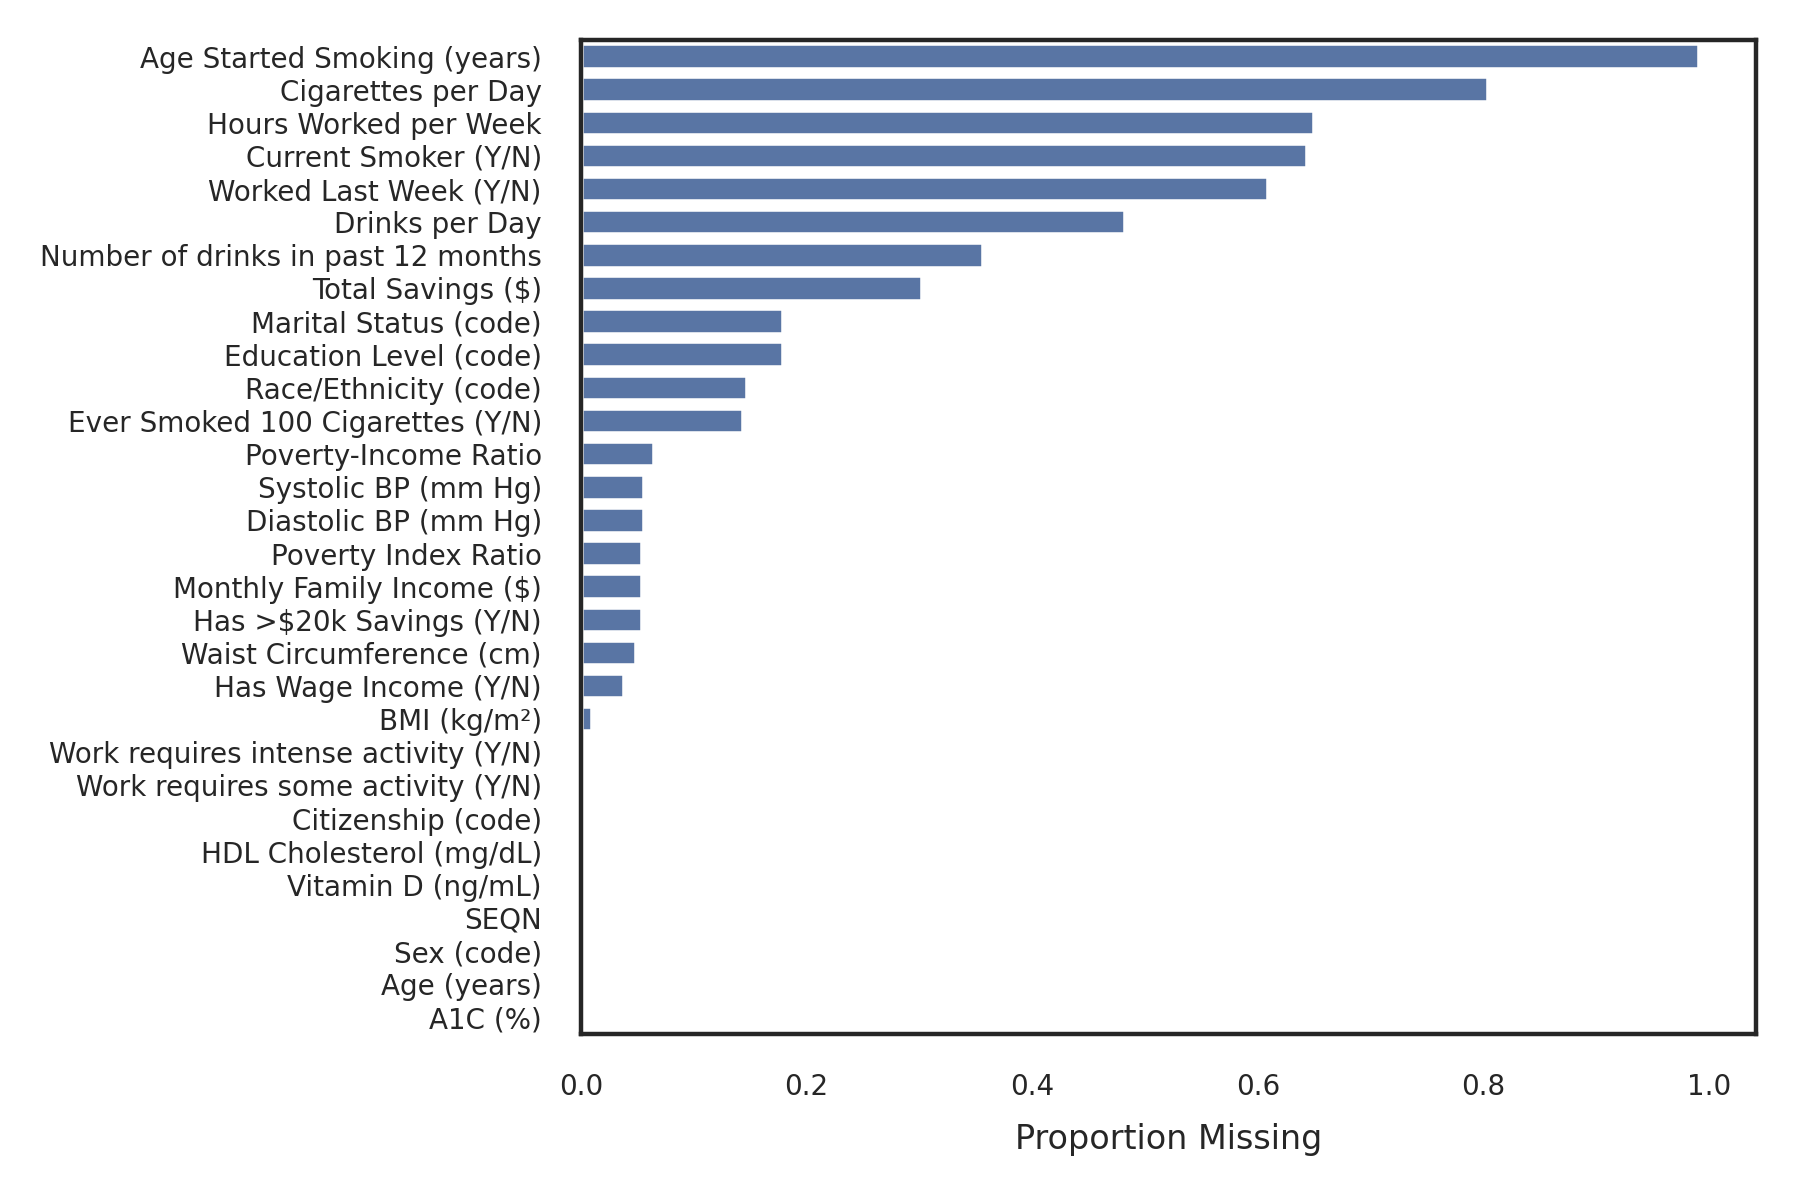

In [13]:
# Compute missing ratios from df_model
missing = df_model.isnull().mean().sort_values(ascending=False)

# Map raw column names to display labels using your dictionary
display_names = [display_name_map.get(col, col) for col in missing.index]

# Set figure height adaptively but cap max height
fig_height = min(0.18 * len(missing), 3)
fig, ax = plt.subplots(figsize=(4.5, fig_height))

sns.barplot(x=missing, y=display_names, color='#4C72B0', ax=ax)

ax.set_xlabel("Proportion Missing", fontsize=6)
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=5)
ax.tick_params(axis='x', labelsize=5)
ax.grid(False)

plt.tight_layout()
plt.show()

In [14]:
# Calculate missingness
missing_ratio = df_model.isnull().mean()

# Find columns with >50% missing
cols_to_drop = missing_ratio[missing_ratio > 0.5].index.tolist()

# Drop them from the DataFrame
df_model = df_model.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} columns:")
print(cols_to_drop)

Dropped 5 columns:
['current_smoker', 'cigs_per_day', 'age_started_smoking', 'worked_last_week', 'hours_worked_week']


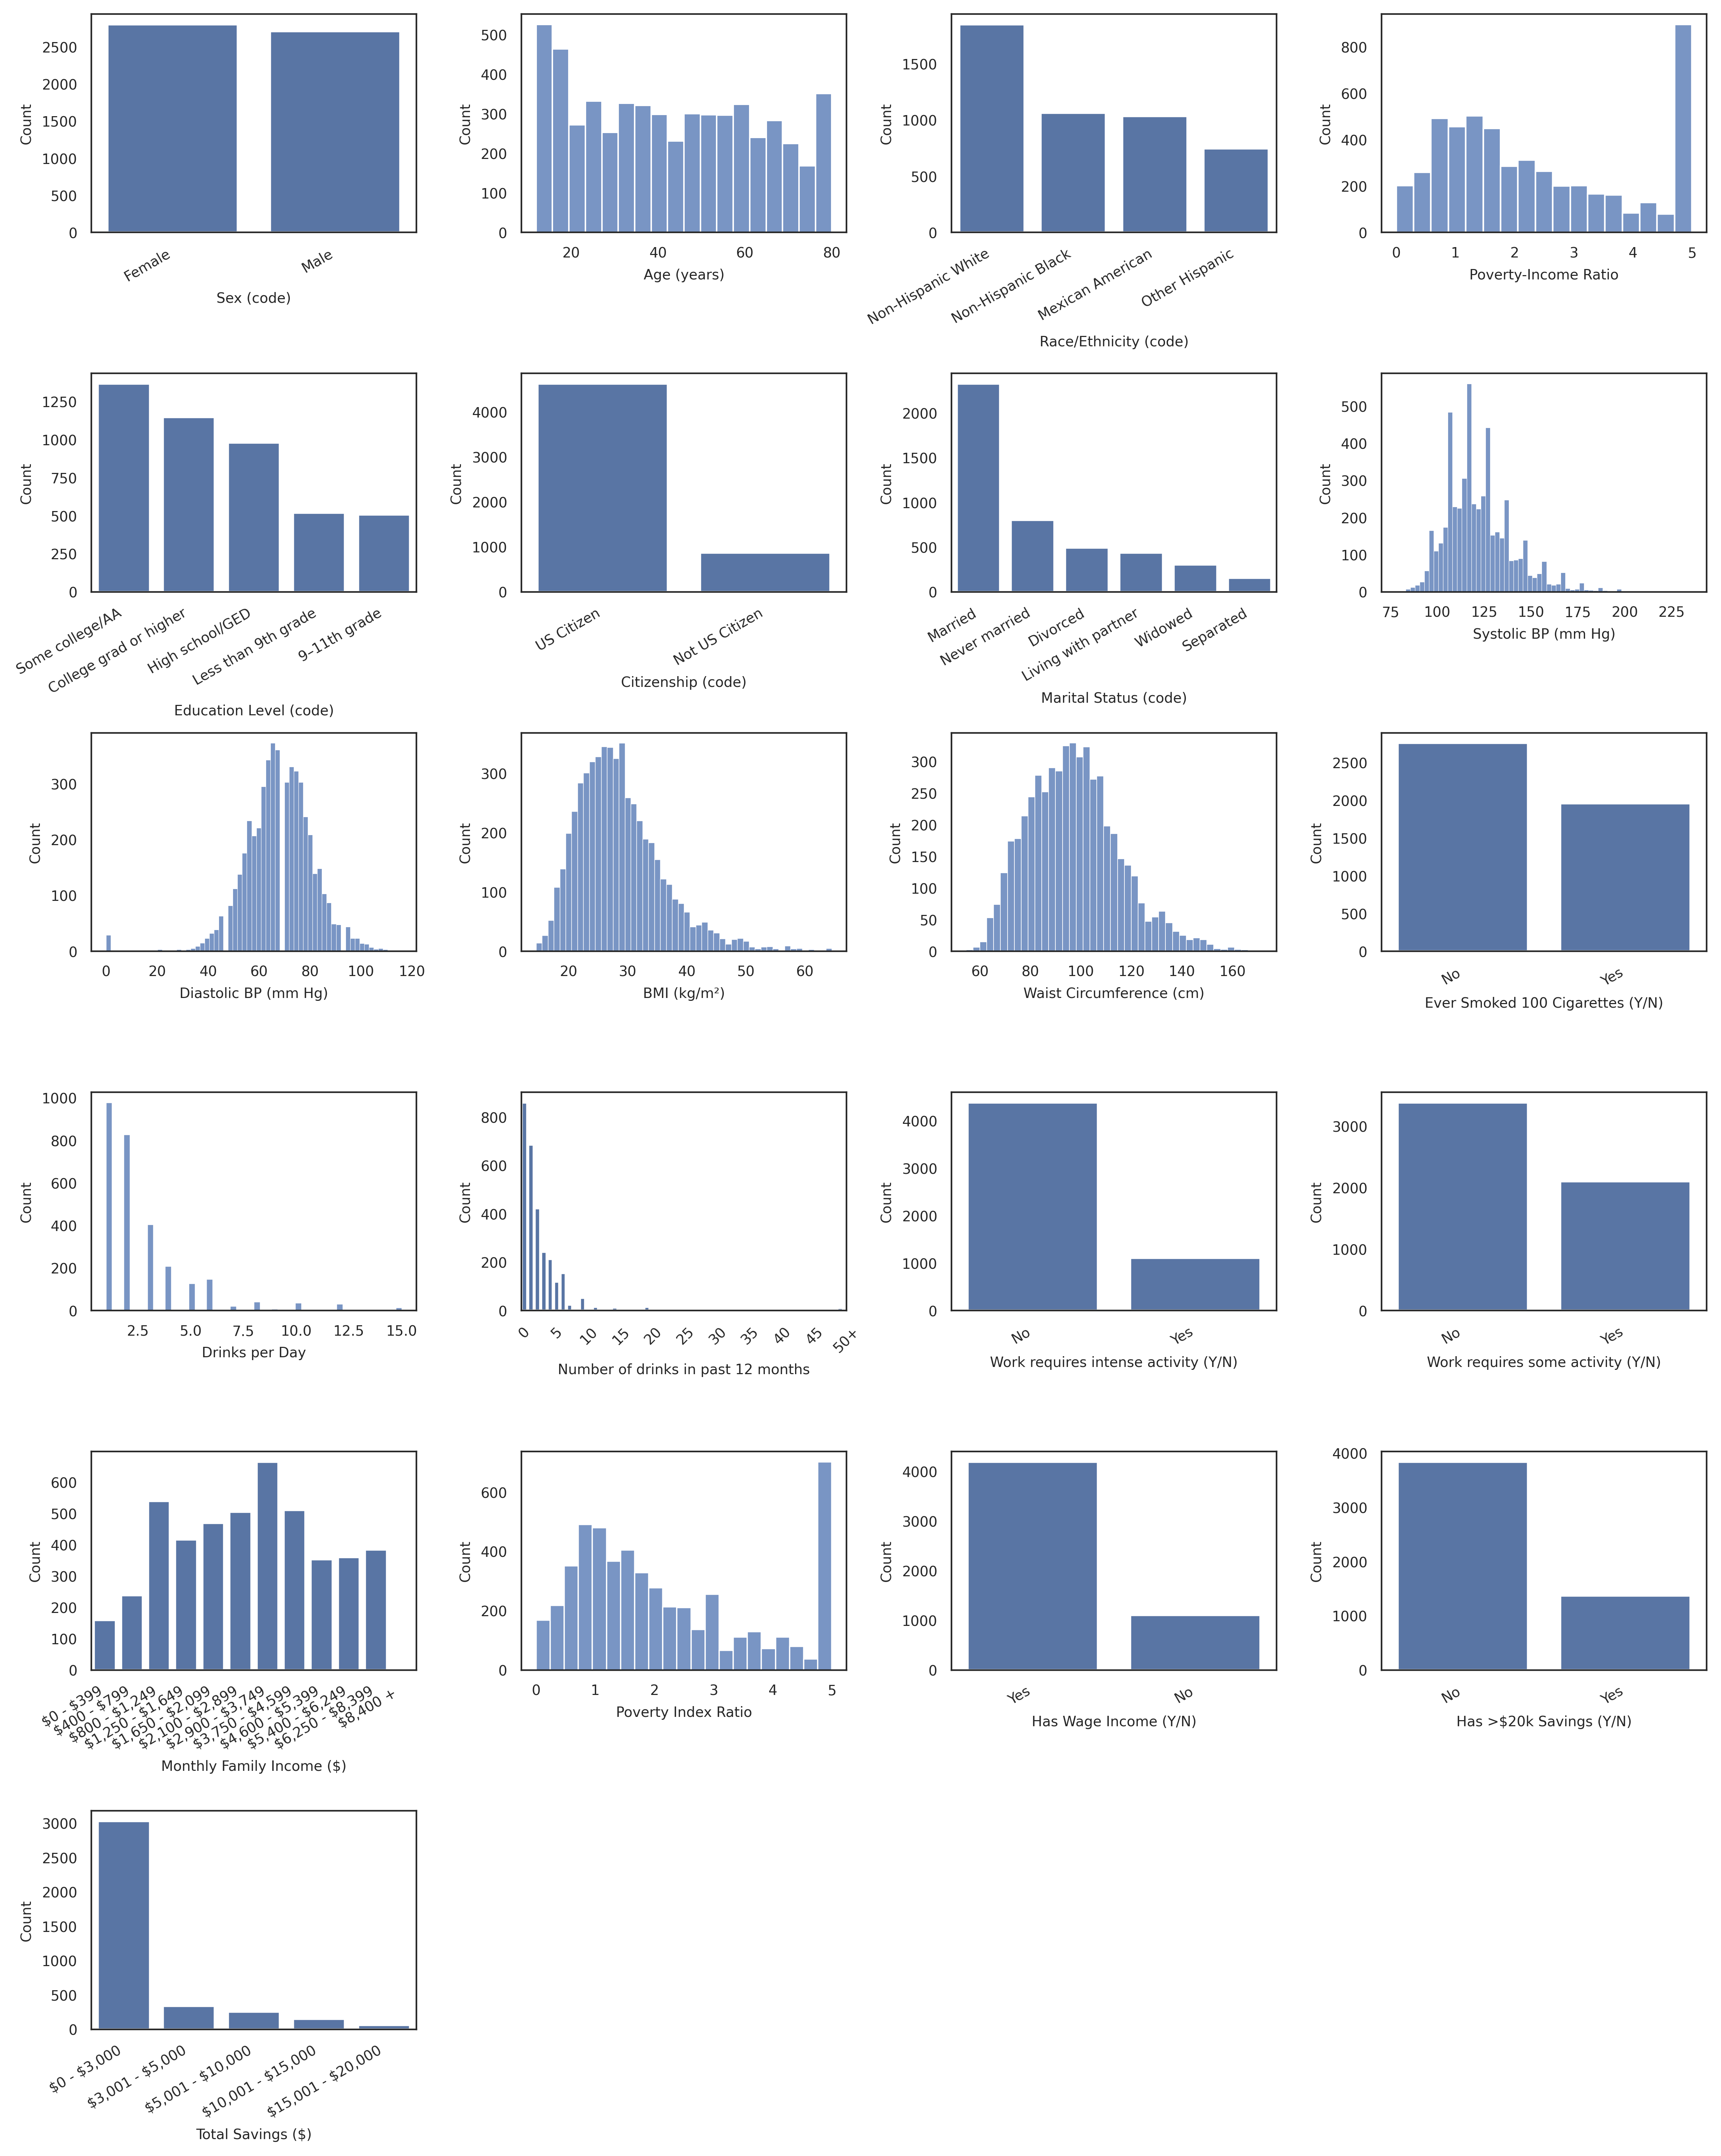

In [35]:
# Manual order for categorical columns
manual_orders = {
    'total_savings': [
        '$0 - $3,000', '$3,001 - $5,000', '$5,001 - $10,000',
        '$10,001 - $15,000', '$15,001 - $20,000'
    ],
    'monthly_family_income': [
        '$0 - $399', '$400 - $799', '$800 - $1,249', '$1,250 - $1,649', '$1,650 - $2,099',
        '$2,100 - $2,899', '$2,900 - $3,749', '$3,750 - $4,599', '$4,600 - $5,399',
        '$5,400 - $6,249', '$6,250 - $8,399', '$8,400 + '
    ]
}

# Features to plot
features = [col for col in df_model.columns if col not in ['SEQN', 'vitamin_d', 'hdl_cholesterol', 'a1c']]

# Subplot layout
n_cols = 4
n_rows = int(np.ceil(len(features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))
axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]
    label = display_name_map.get(col, col)
    series = df_model[col]
    is_cat = series.dtype == 'object' or series.nunique() <= 10

    if col == 'alc_freq_past12mo':
        clipped = series.copy()
        clipped[clipped > 50] = 50
        clipped = clipped[clipped.notna()]
        sns.countplot(x=clipped, ax=ax, color='#4C72B0', order=range(1, 51))
        ax.set_xticks(list(range(0, 50, 5)) + [50])
        ax.set_xticklabels([str(i) for i in range(0, 50, 5)] + ['50+'], rotation=45)

    elif is_cat:
        order = manual_orders.get(col, series.value_counts().index)
        sns.countplot(x=col, data=df_model, ax=ax, color='#4C72B0', order=order)
        tick_labels = [label.get_text().replace('$', r'\$') for label in ax.get_xticklabels()]
        ax.set_xticklabels(tick_labels, rotation=30, ha='right')

    else:
        sns.histplot(series, bins='fd', kde=False, ax=ax, color='#4C72B0')
        ax.tick_params(axis='x')

    ax.set_xlabel(label)
    ax.set_ylabel('Count')
    ax.grid(False)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

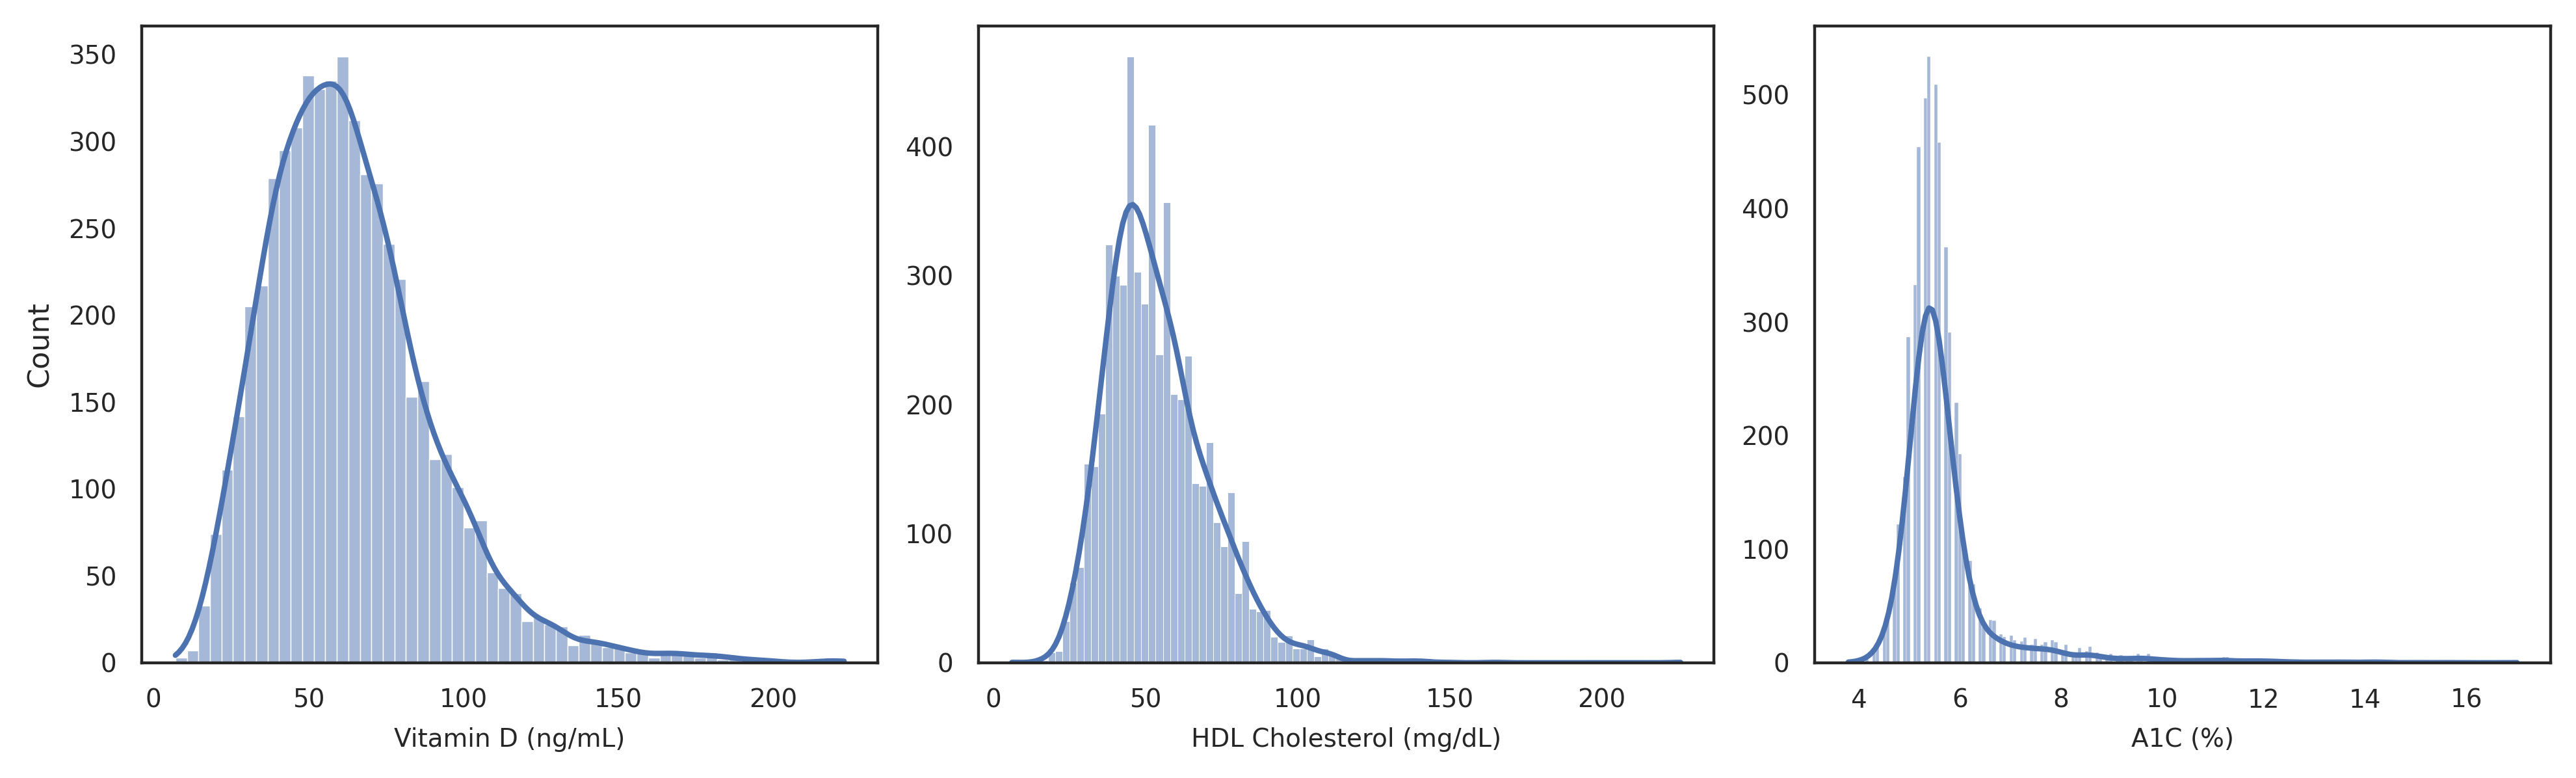

In [39]:
# Target columns
targets = ['vitamin_d', 'hdl_cholesterol', 'a1c']

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for i, col in enumerate(targets):
    label = display_name_map.get(col, col)
    sns.histplot(df_model[col], bins='auto', kde=True, ax=axes[i], color='#4C72B0')
    axes[i].set_xlabel(label)
    axes[i].set_ylabel("Count" if i == 0 else "", fontsize=8)
    axes[i].tick_params(axis='both', labelsize=7)
    axes[i].grid(False)

plt.tight_layout()
plt.show()


In [41]:
# Compute summary stats
summary = df_model.drop(columns='SEQN').describe().T
summary = summary.round(2)

# Rename index using display names
summary.index = [display_name_map.get(col, col) for col in summary.index]

# Display
summary

count    mean    std    min     25%  \
Age (years)                         5512.0   43.01  20.48  12.00   25.00   
Poverty-Income Ratio                5149.0    2.39   1.58   0.00    1.08   
Systolic BP (mm Hg)                 5197.0  122.63  18.12  78.00  110.00   
Diastolic BP (mm Hg)                5197.0   67.89  13.30   0.00   60.00   
BMI (kg/m²)                         5451.0   28.70   7.23  14.50   23.60   
Waist Circumference (cm)            5235.0   97.28  17.84  54.60   84.00   
Drinks per Day                      2849.0    2.73   2.31   1.00    1.00   
Number of drinks in past 12 months  3541.0    3.06  10.96   0.00    1.00   
Poverty Index Ratio                 5209.0    2.20   1.52   0.00    0.99   
Vitamin D (ng/mL)                   5512.0   63.66  27.33   7.04   44.40   
HDL Cholesterol (mg/dL)             5512.0   53.89  16.92   6.00   42.00   
A1C (%)                             5512.0    5.73   1.09   3.80    5.20   

                                       50%     75%    max  
Age (years)                          42.00   60.00   80.0  
Poverty-Income Ratio                  1.98    3.70    5.0  
Systolic BP (mm Hg)                 120.00  132.00  236.0  
Diastolic BP (mm Hg)                 68.00   76.00  116.0  
BMI (kg/m²)                          27.60   32.50   64.6  
Waist Circumference (cm)             96.40  108.00  171.6  
Drinks per Day                        2.00    3.00   15.0  
Number of drinks in past 12 months    2.00    3.00  365.0  
Poverty Index Ratio                   1.73    3.12    5.0  
Vitamin D (ng/mL)                    60.10   77.70  223.0  
HDL Cholesterol (mg/dL)              51.00   63.00  226.0  
A1C (%)                               5.50    5.80   17.0

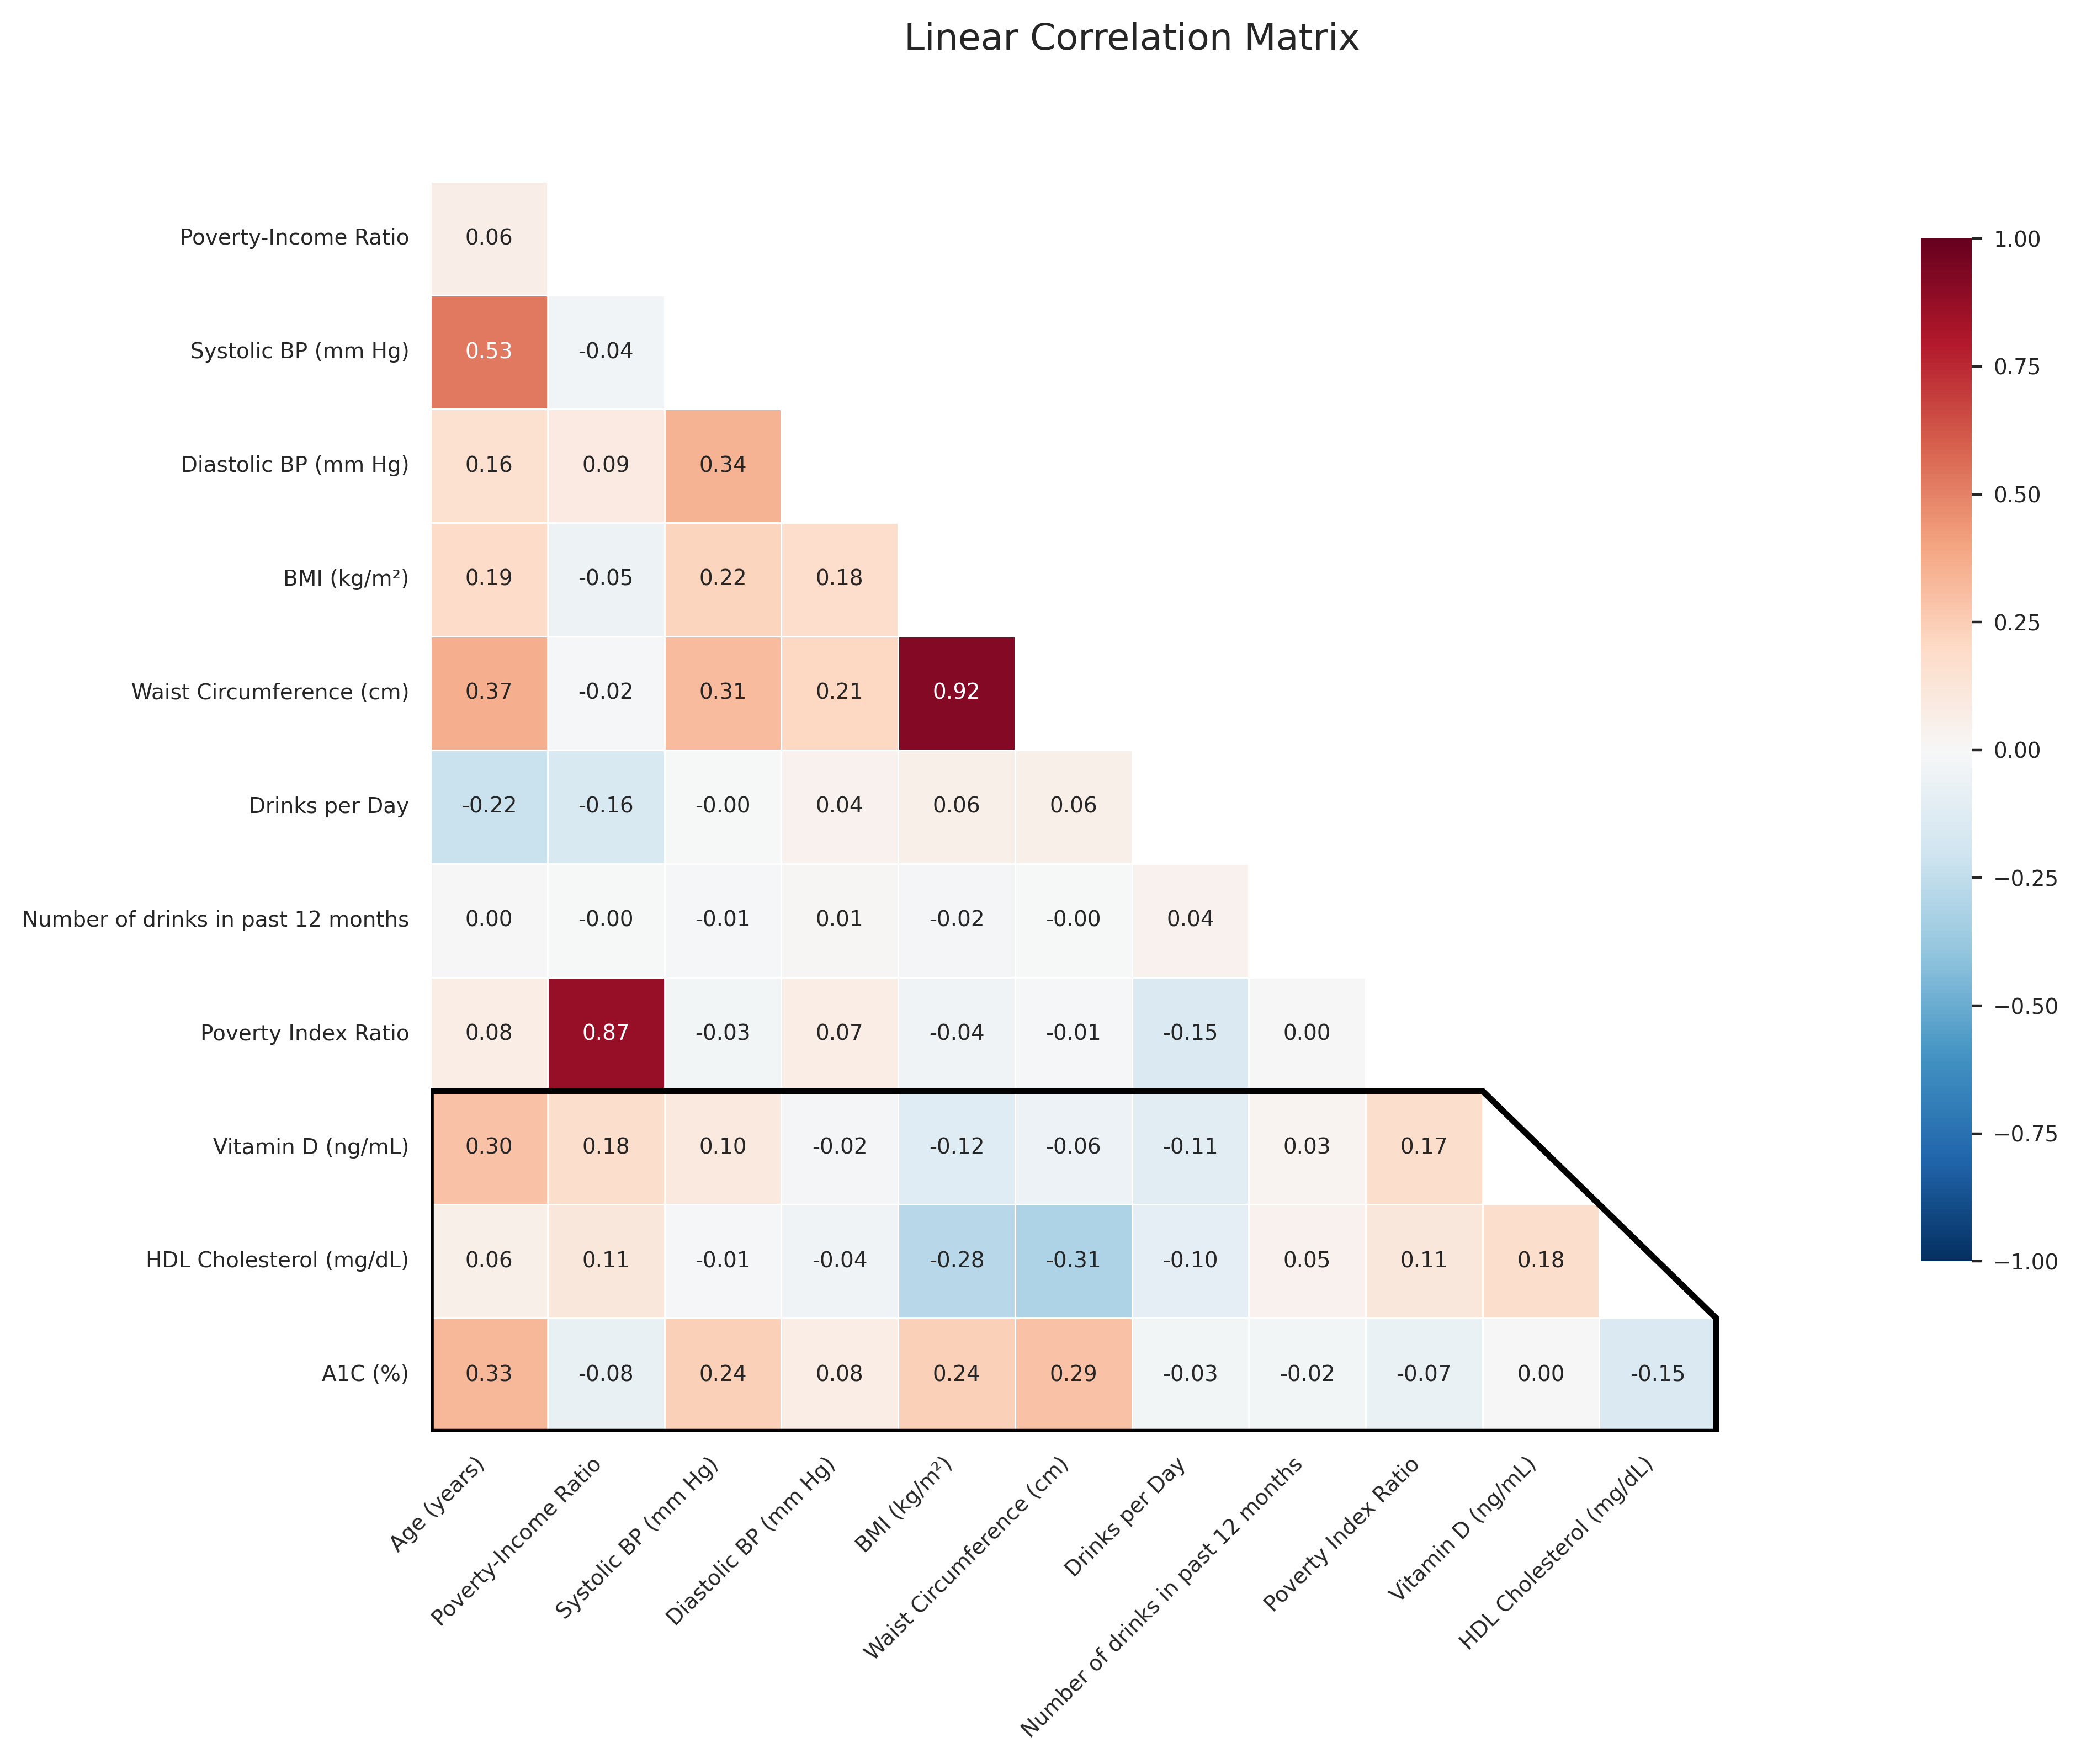

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# Compute correlation matrix
corr = df_model.drop(columns='SEQN').corr(numeric_only=True)

# Rename with display names
renamed = [display_name_map.get(col, col) for col in corr.columns]
corr.index = renamed
corr.columns = renamed

# Define target variable display names
target_labels = [display_name_map[t] for t in ['vitamin_d', 'hdl_cholesterol', 'a1c']]
target_rows = [corr.index.get_loc(t) for t in target_labels]

# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    cbar_kws={"shrink": 0.75},
    ax=ax
)

# Build one polygon around all three target rows (lower triangle portion)
min_row = min(target_rows)
max_row = max(target_rows)
polygon_points = [
    [0, min_row],                  # left bottom
    [min_row, min_row],           # left top
    [max_row, max_row],           # right top
    [max_row, max_row + 1],       # right bottom
    [0, max_row + 1]              # left bottom again
]

polygon = patches.Polygon(polygon_points, closed=True, fill=False, edgecolor='black', linewidth=2)
ax.add_patch(polygon)

# Whiten irrelevant labels
for tick in ax.get_xticklabels():
    if tick.get_text() == display_name_map['a1c']:
        tick.set_color('white')
for tick in ax.get_yticklabels():
    if tick.get_text() == display_name_map['age']:
        tick.set_color('white')

plt.title("Linear Correlation Matrix", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

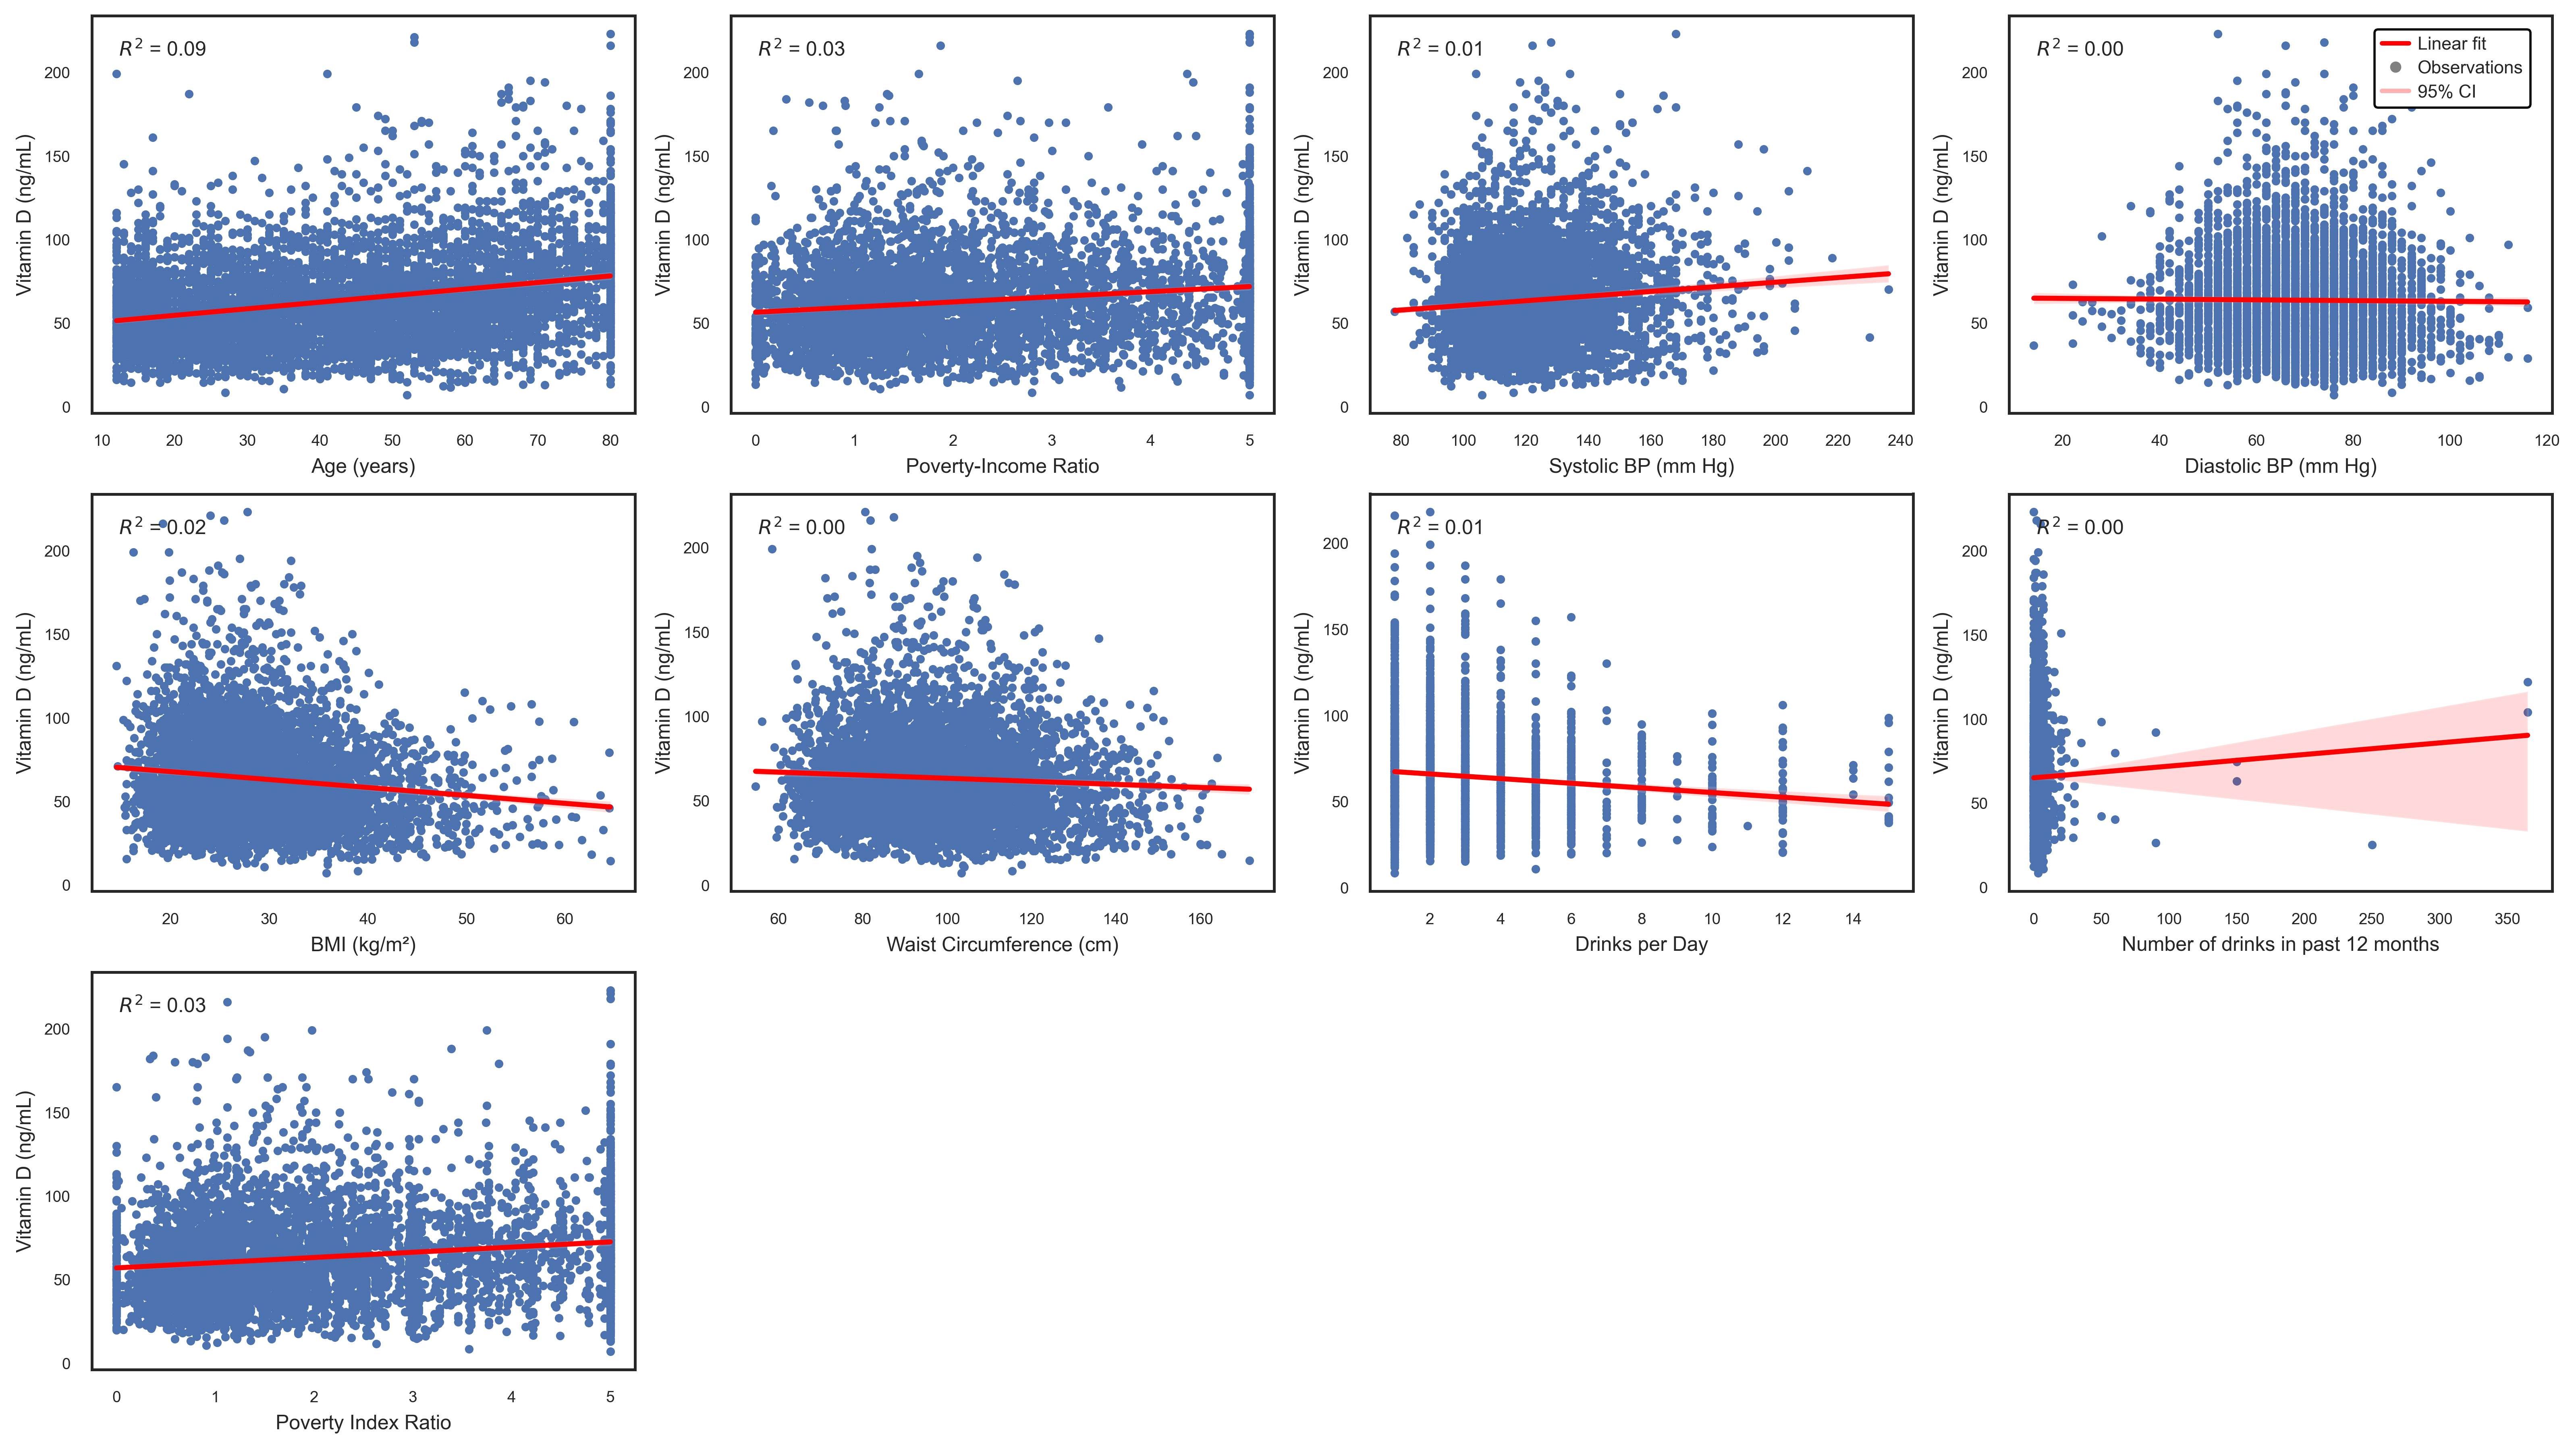

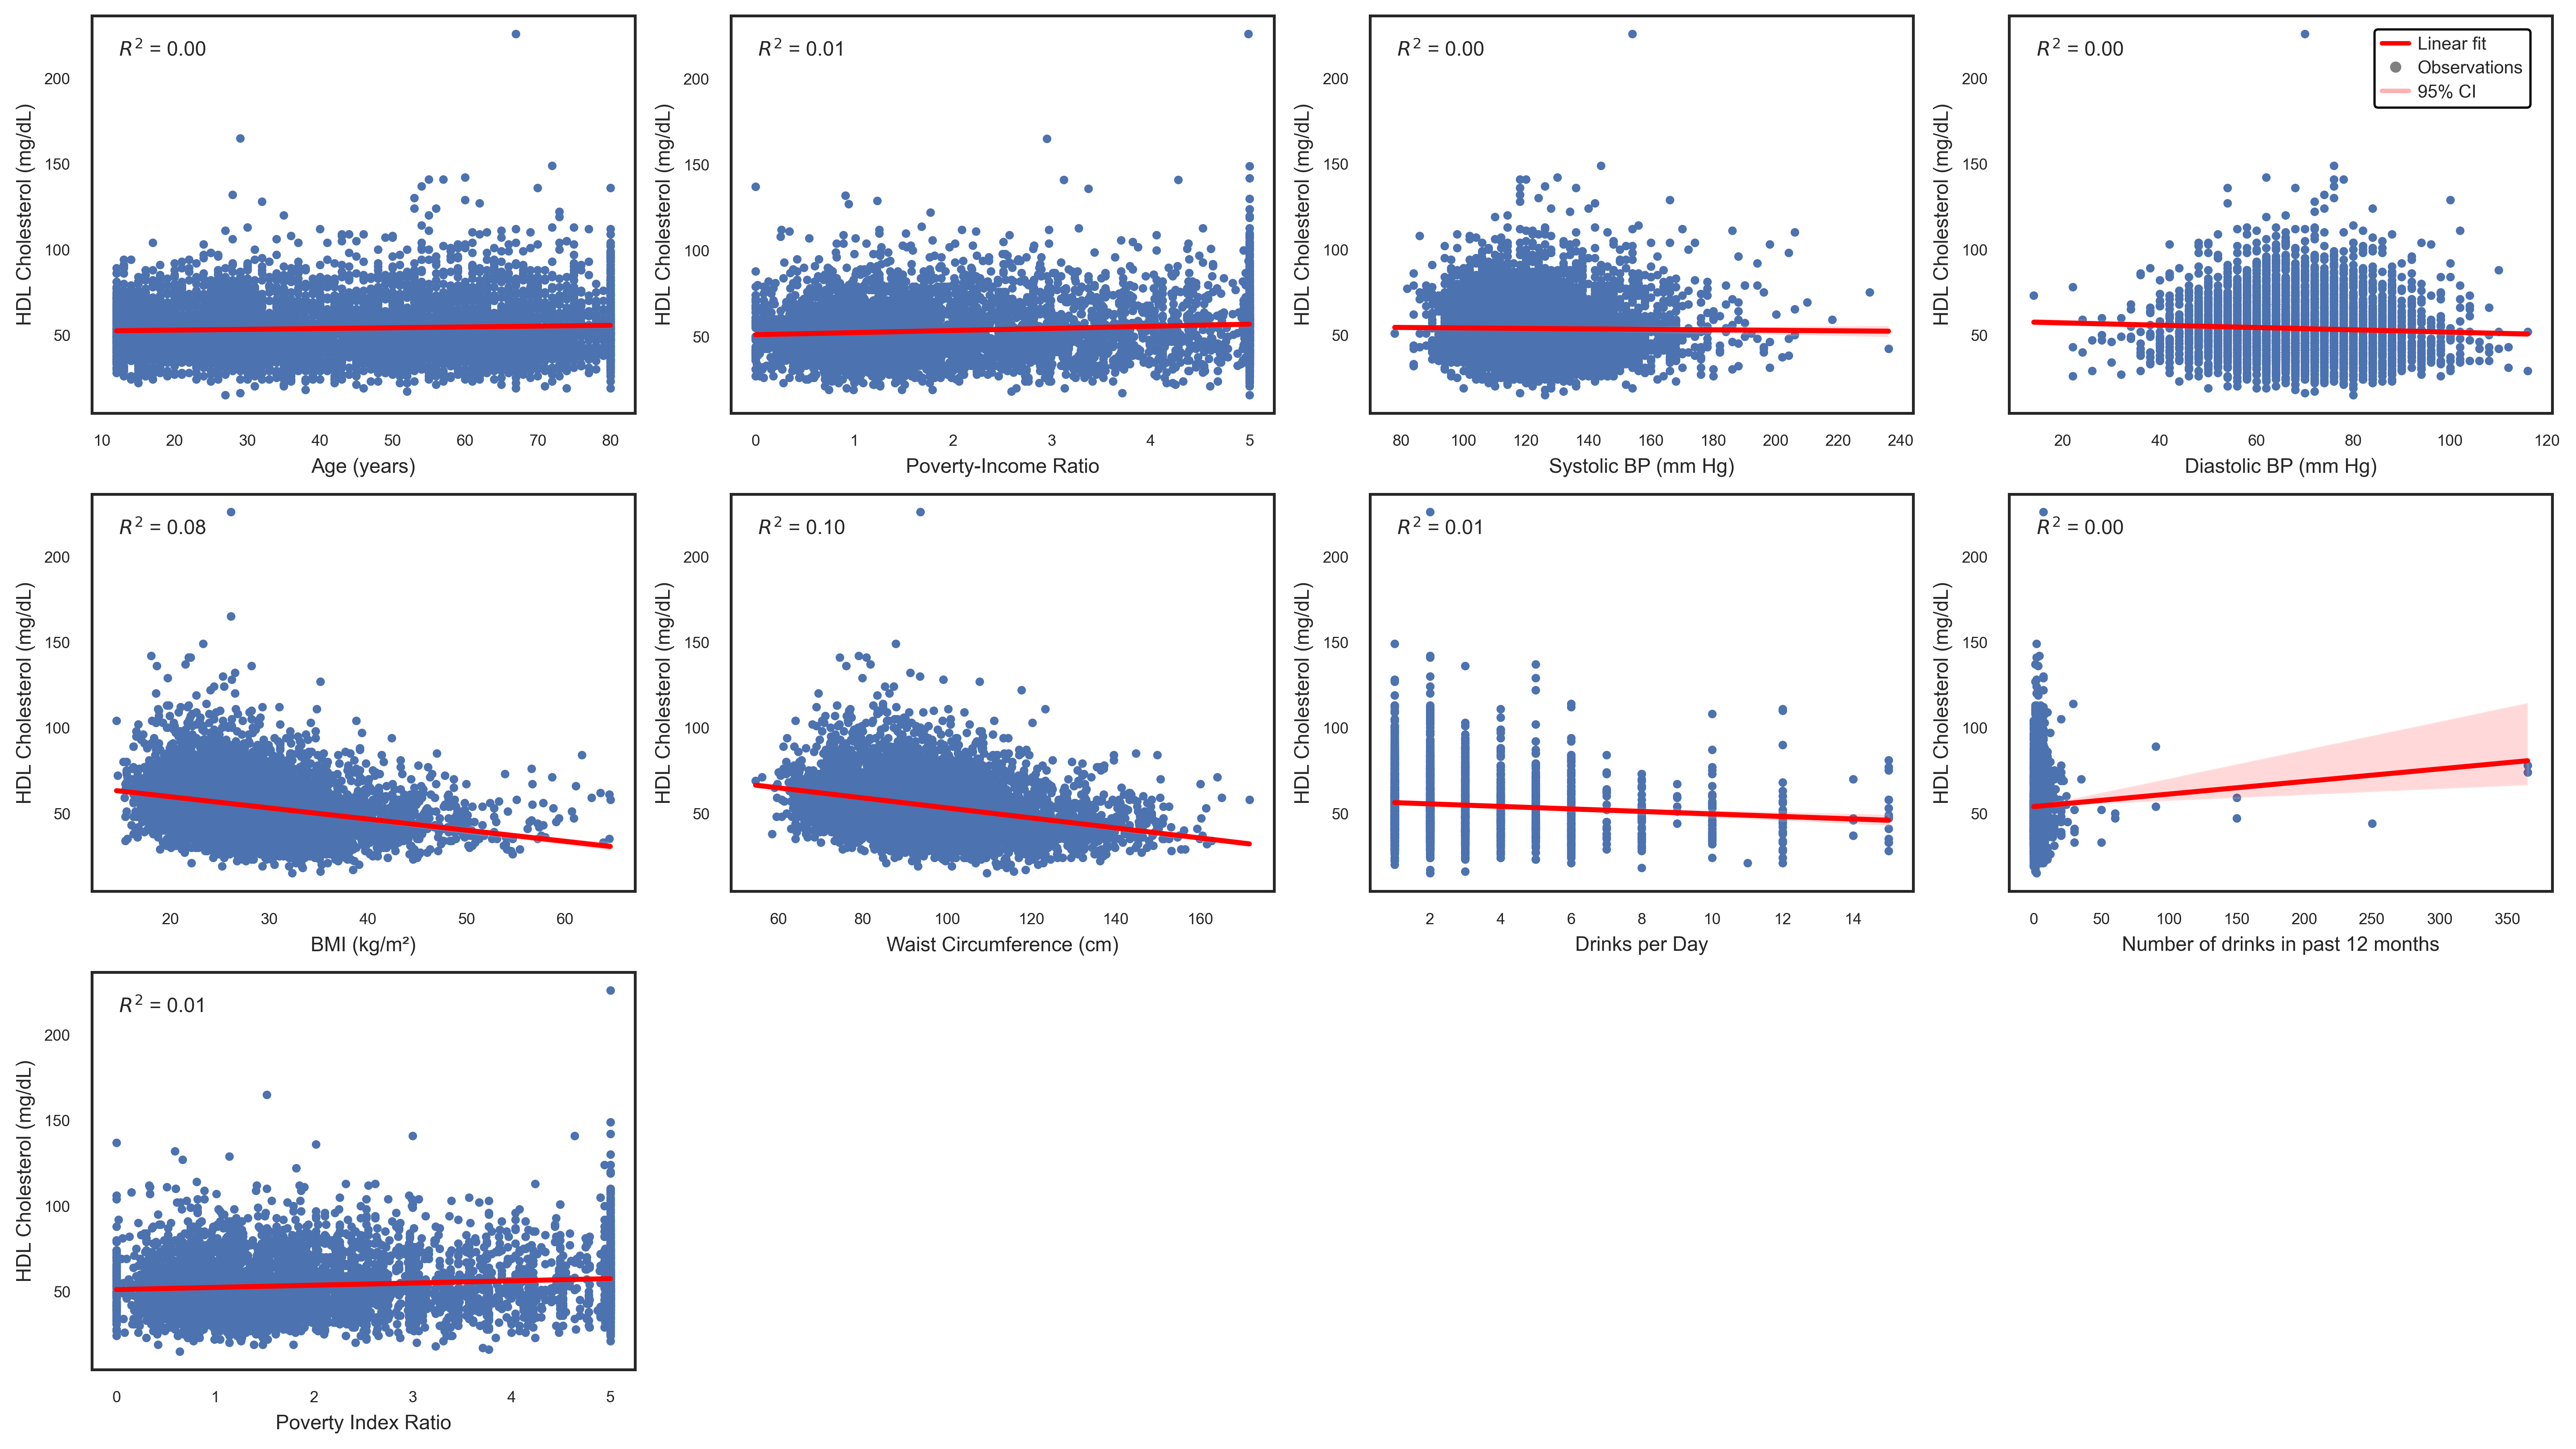

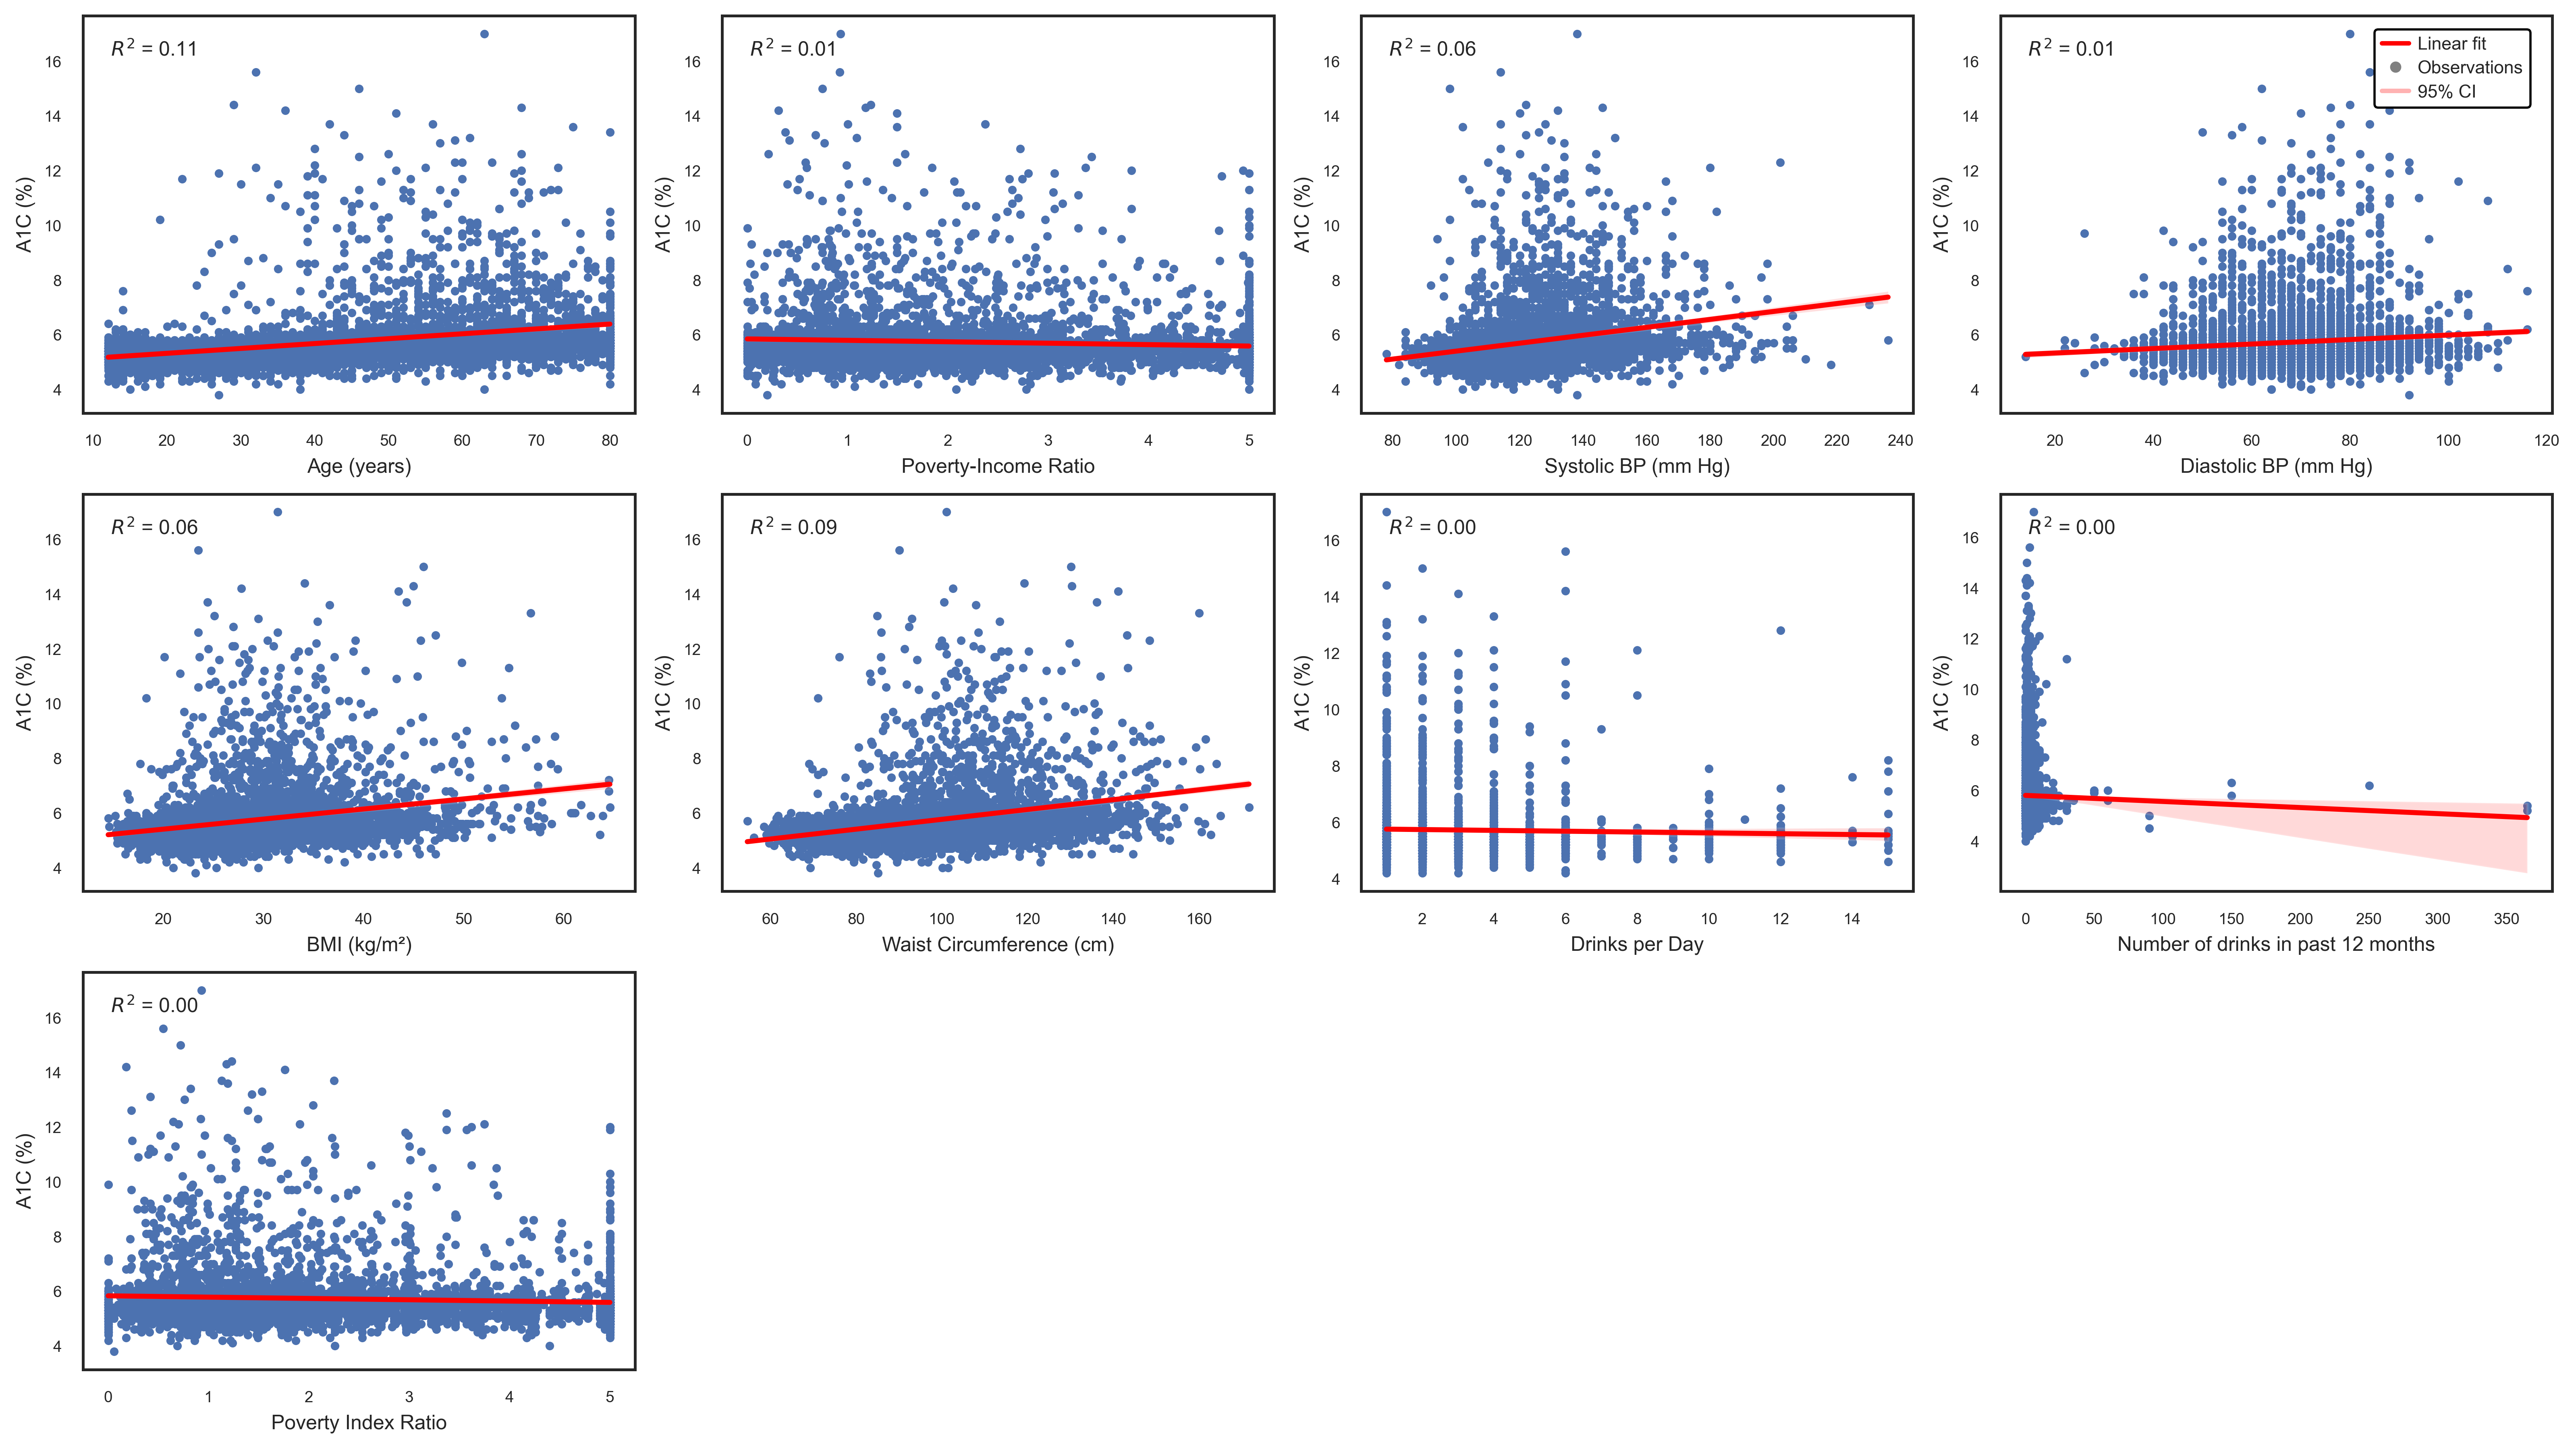

In [133]:
# Target and feature selection
target_vars = ['vitamin_d', 'hdl_cholesterol', 'a1c']
numeric_features = df_model.select_dtypes(include=[np.number]).columns.drop(['SEQN'] + target_vars)

# R² summary table
r2_table = pd.DataFrame(index=numeric_features, columns=target_vars)

# Plot style
sns.set_style("white")
n_cols = 4
n_rows = int(np.ceil(len(numeric_features) / n_cols))

for target in target_vars:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(numeric_features):
        ax = axes[i]

        # Drop NaNs
        subset = df_model[[feature, target]].dropna()
        X = subset[[feature]].values
        y = subset[target].values

        # Fit and compute R²
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        r2_table.loc[feature, target] = r2

        # Plot with regression line + CI
        sns.regplot(
            x=feature,
            y=target,
            data=df_model,
            ax=ax,
            ci=95,
            scatter_kws={'alpha': 1, 's': 8},
            line_kws={'color': 'red'}
        )

        # Axes and annotation
        ax.set_xlabel(display_name_map.get(feature, feature), fontsize=9)
        ax.set_ylabel(display_name_map.get(target, target), fontsize=9)
        ax.set_title("")
        ax.grid(False)
        ax.annotate(f"$R^2$ = {r2:.2f}", xy=(0.05, 0.90), xycoords="axes fraction", fontsize=9)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Shared legend (only once per figure)
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='Linear fit'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, alpha=1, label='Observations'),
        Line2D([0], [0], color='red', lw=2, alpha=0.3, label='95% CI')
    ]
    fig.legend(
        handles=legend_elements,
        loc='upper right',
        bbox_to_anchor=(0.985, 0.985),
        frameon=True,
        facecolor='white',
        edgecolor='black',
        framealpha=1,
        fontsize=8,              # smaller text
        handlelength=1.5,        # shorten line length in legend
        handletextpad=0.5,       # reduce space between handle and text
        borderpad=0.4,           # tighter padding inside box
        labelspacing=0.4         # tighter vertical spacing
    )
    plt.tight_layout()
    plt.show()


vitamin_d  hdl_cholesterol    a1c
age                        0.086            0.003  0.112
poverty_income_ratio       0.032            0.013  0.006
systolic_bp                0.008            0.000  0.058
diastolic_bp               0.000            0.002  0.009
bmi                        0.016            0.077  0.061
waist_circumference        0.004            0.096  0.088
drinks_per_day             0.013            0.009  0.001
alc_freq_past12mo          0.001            0.002  0.001
monthly_poverty_ratio      0.030            0.013  0.005

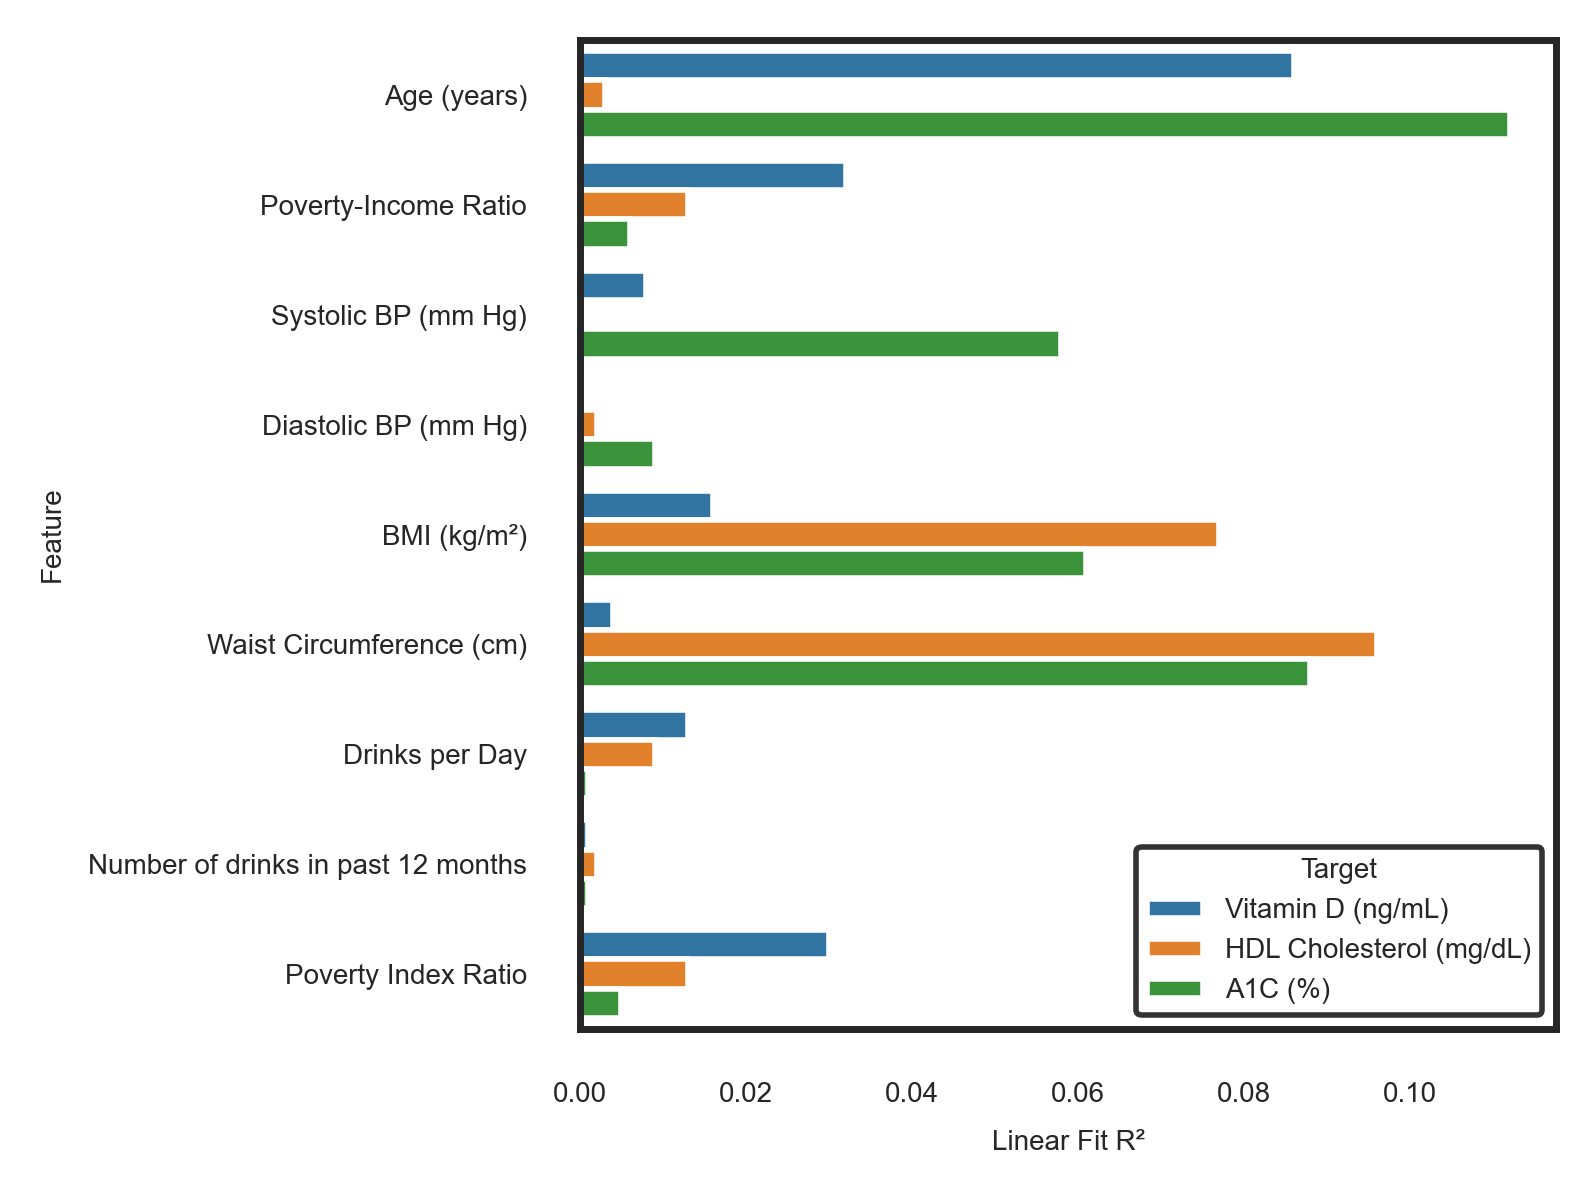

In [209]:
# Show summary R² table
r2_table = r2_table.astype(float).round(3)
display(r2_table)

# Prepare long-form R² DataFrame
r2_long = (
    r2_table.reset_index()
    .melt(id_vars='index', var_name='Target', value_name='R²')
    .rename(columns={'index': 'Feature'})
)

# Map display names
r2_long['Display Feature'] = r2_long['Feature'].map(display_name_map)
r2_long['Display Target'] = r2_long['Target'].map(display_name_map)

# Define color palette
palette = {
    display_name_map['vitamin_d']: '#1f77b4',
    display_name_map['hdl_cholesterol']: '#ff7f0e',
    display_name_map['a1c']: '#2ca02c'
}

# Plot
plt.figure(figsize=(4, 3))  # Small fixed figure
sns.barplot(
    data=r2_long,
    x='R²',
    y='Display Feature',
    hue='Display Target',
    palette=palette
)

# Formatting
plt.xlabel('Linear Fit R²', fontsize=5)
plt.ylabel('Feature', fontsize=5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.legend(title='Target', 
        fontsize=5, 
        title_fontsize=5, 
        loc='lower right',
        frameon=True,
        facecolor='white',
        edgecolor='black',)
plt.tight_layout()
plt.show()



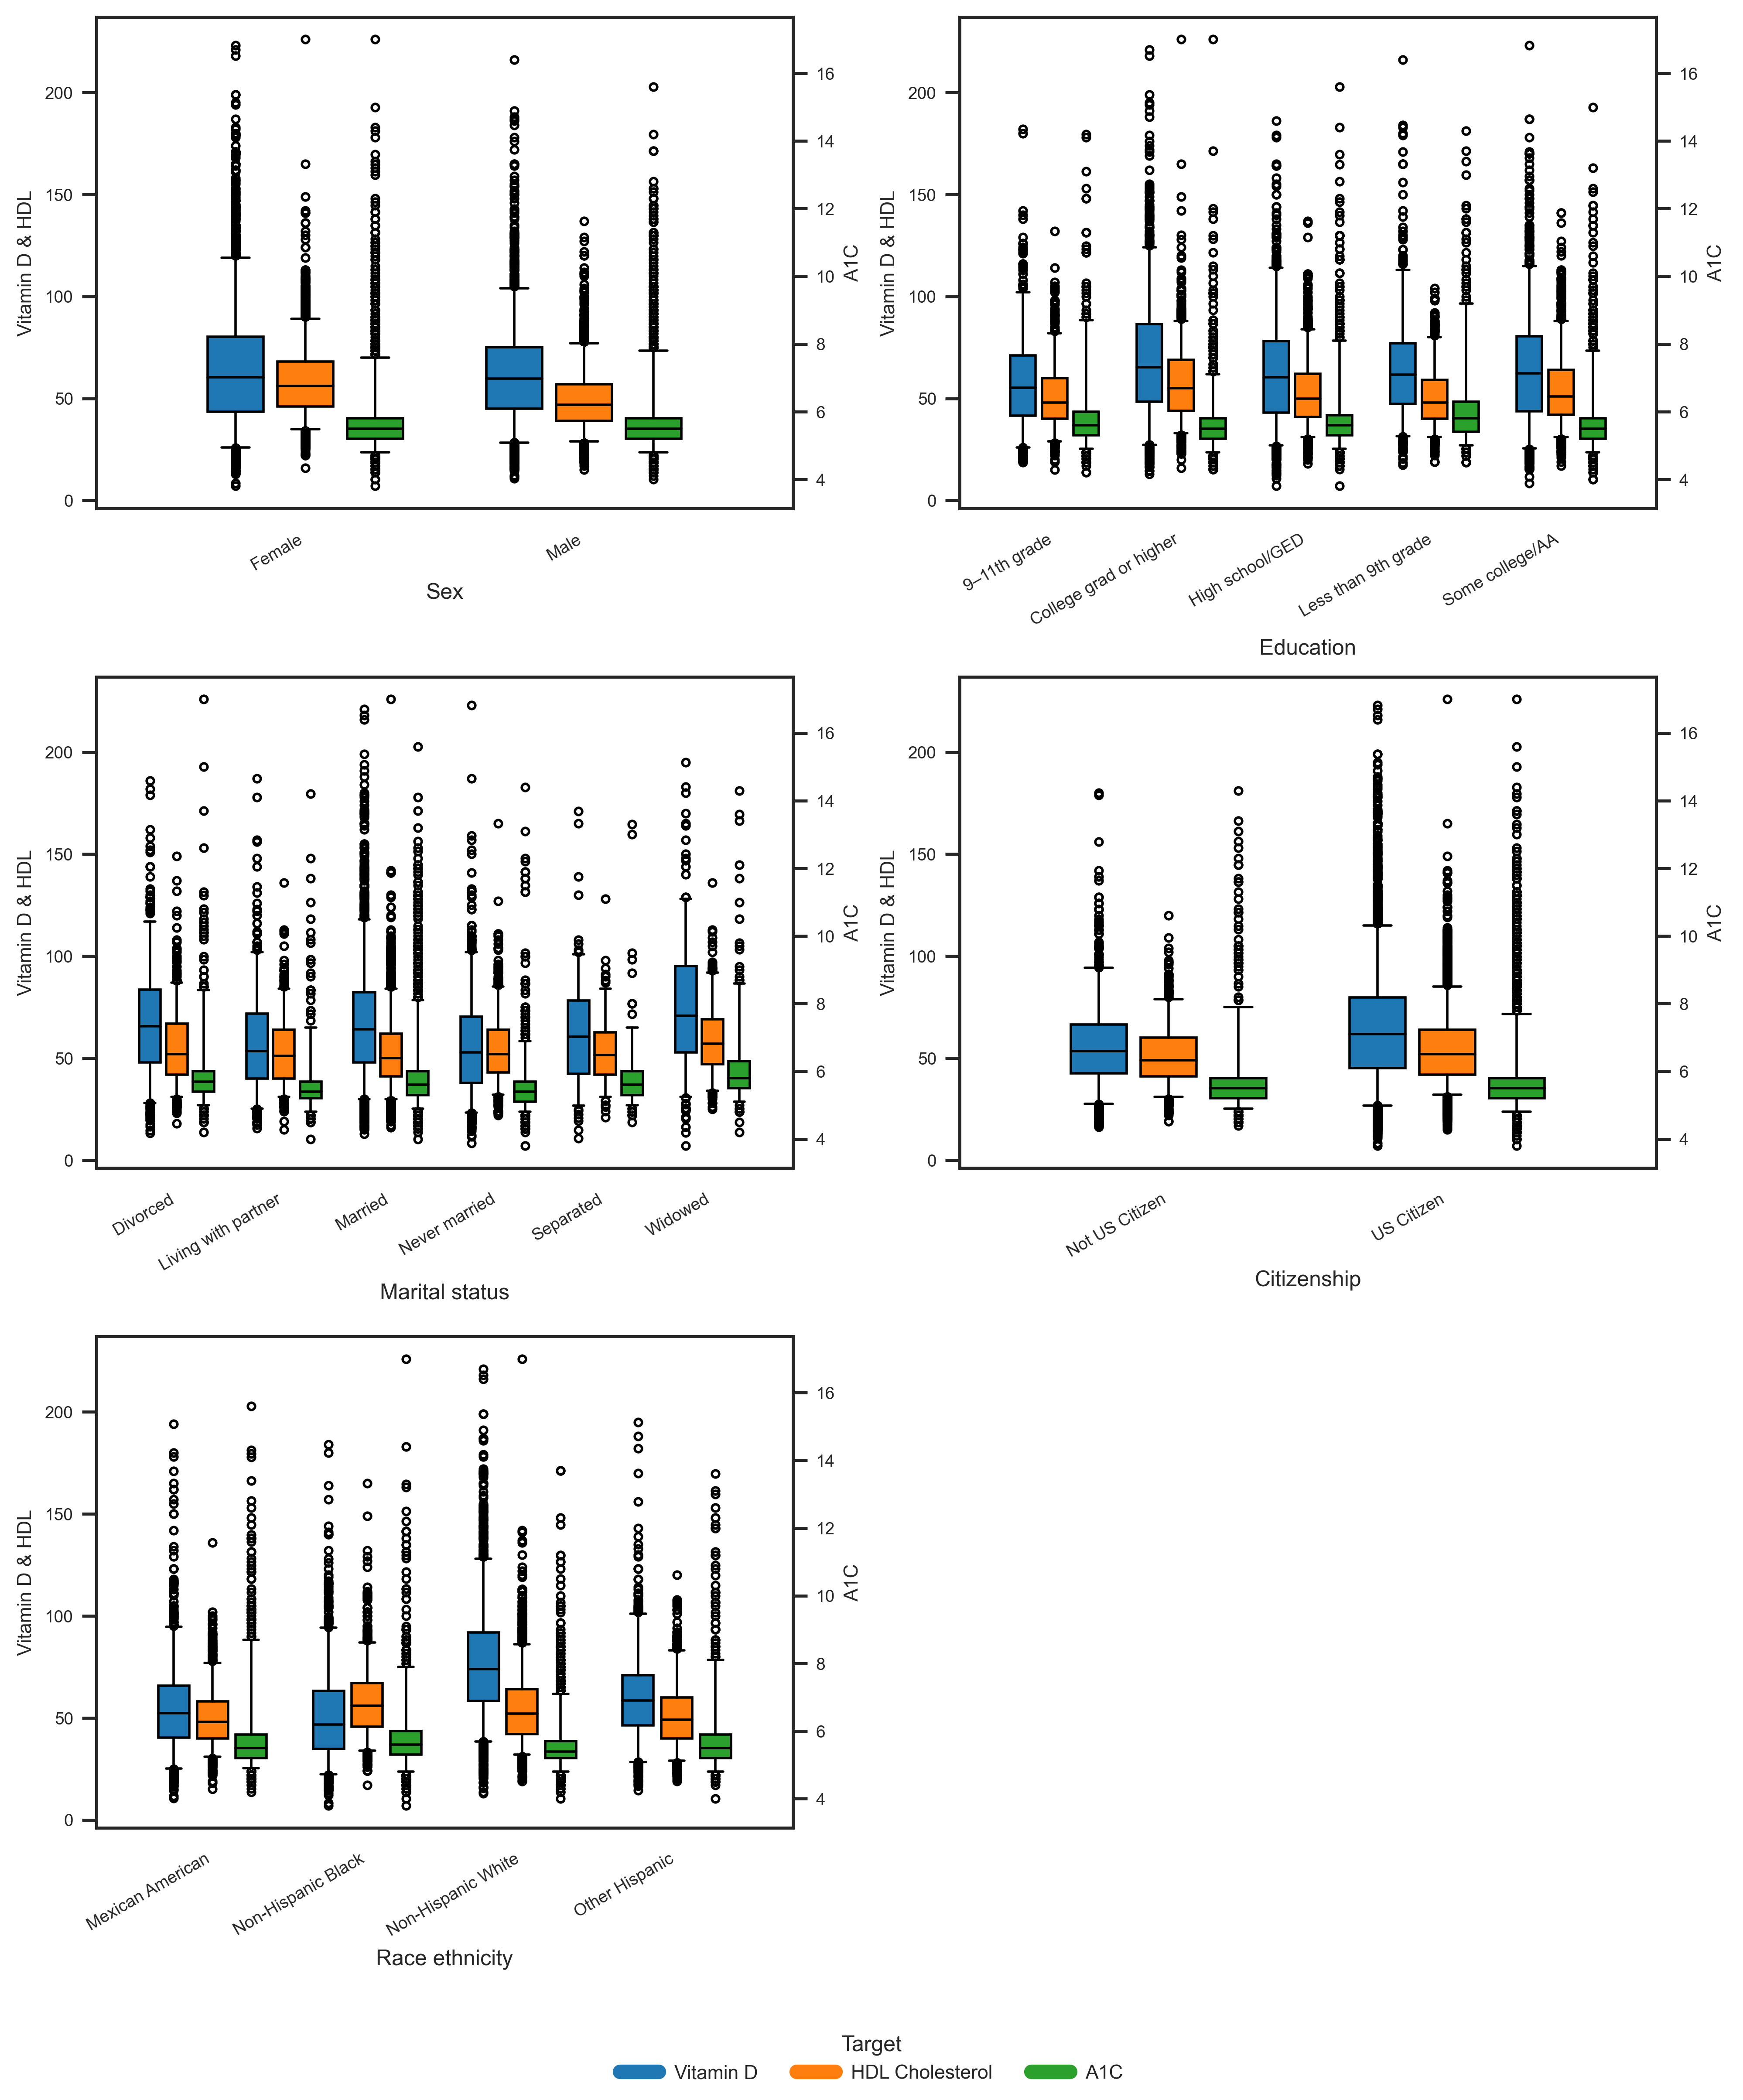

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Set your categorical features ===
cat_features = ['sex', 'education', 'marital_status', 'citizenship', 'race_ethnicity']  # add more if needed

# === Targets ===
vitd = 'vitamin_d'
hdl = 'hdl_cholesterol'
a1c = 'a1c'

# === Colors ===
colors = {
    vitd: '#1f77b4',          # Blue
    hdl: '#ff7f0e',           # Orange
    a1c: '#2ca02c'            # Green
}

# === Boxplot styling ===
box_param = dict(
    whis=(5, 95), widths=0.2, patch_artist=True,
    flierprops=dict(marker='.', markeredgecolor='black', fillstyle='none'),
    medianprops=dict(color='black')
)

# === Plot layout ===
n_cols = 2
n_rows = int(np.ceil(len(cat_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, cat in enumerate(cat_features):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # Clean data
    df_clean = df_model[[cat, vitd, hdl, a1c]].dropna()
    categories = sorted(df_clean[cat].unique())
    nb_groups = len(categories)

    # Skip if only 1 category
    if nb_groups < 2:
        ax1.axis('off')
        continue

    # Prepare boxplot data
    df_pivot = df_clean.pivot(columns=cat)
    vitd_data = [df_pivot[vitd][c].dropna() for c in categories]
    hdl_data  = [df_pivot[hdl][c].dropna() for c in categories]
    a1c_data  = [df_pivot[a1c][c].dropna() for c in categories]

    space = 0.25
    positions_vitd = np.arange(nb_groups) - space
    positions_hdl  = np.arange(nb_groups)
    positions_a1c  = np.arange(nb_groups) + space

    # Boxplots: left y-axis
    ax1.boxplot(vitd_data, positions=positions_vitd,
                boxprops=dict(facecolor=colors[vitd]), **box_param)
    ax1.boxplot(hdl_data, positions=positions_hdl,
                boxprops=dict(facecolor=colors[hdl]), **box_param)

    # Boxplot: right y-axis
    ax2.boxplot(a1c_data, positions=positions_a1c,
                boxprops=dict(facecolor=colors[a1c]), **box_param)

    # Axes labels
    ax1.set_xticks(np.arange(nb_groups))
    ax1.set_xticklabels(categories, rotation=30, ha='right', fontsize=8)
    ax1.set_xlabel(cat.replace('_', ' ').capitalize(), fontsize=9)
    ax1.set_ylabel('Vitamin D & HDL', fontsize=8)
    ax2.set_ylabel('A1C', fontsize=8)

    ax1.tick_params(axis='y', labelsize=7)
    ax2.tick_params(axis='y', labelsize=7)
    ax1.tick_params(axis='x', labelsize=7)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Shared legend
handles = [
    plt.Line2D([0], [0], color=colors[vitd], lw=6, label='Vitamin D'),
    plt.Line2D([0], [0], color=colors[hdl], lw=6, label='HDL Cholesterol'),
    plt.Line2D([0], [0], color=colors[a1c], lw=6, label='A1C'),
]
fig.legend(handles=handles, title='Target', fontsize=8, title_fontsize=9,
           loc='lower center', ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
